In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
plt = matplotlib.pyplot
import tensorflow as tf

import geopandas as gpd
import tensorflow_probability as tfp
from tqdm import tqdm

from scipy.ndimage import maximum_filter


import sys
import importlib

sys.path.append('..')
import nsgp_vi_covar
from nsgp_vi_covar import nsgpVI




import pickle

tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels


In [2]:
(tf.nn.softplus(-9.).numpy()**0.5)*1000

2022-03-16 13:24:36.592668: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-16 13:24:37.761433: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15391 MB memory:  -> device: 0, name: Quadro GP100, pci bus id: 0000:3b:00.0, compute capability: 6.0


11.108653883040533

In [3]:
tf.__version__

'2.6.2'

In [4]:
dfpark = gpd.read_file("../data/wildebeest_data/v4_serengeti_ecosystem.shp")


#Load the data

df = pd.read_csv('../data/wildebeest_data/wildebeest2019e.csv')
# Select all the rows where the OWNER is HOPCRAFT
df = df[df['OWNER'] == 'HOPCRAFT']
#Select all the rows where the species is WB
df = df[df['SPECIES'] == 'WB']
#Select all the rows where the animal is a migrant
df = df[df['migrant'] == 1]
# only use values post 2013 (higher accuracy, more fixes, accurate resident indicator)
df = df[pd.to_datetime(df['Date']).dt.year>=2013]
df = df[df['NDVI'].notna()]
#df = df[df.steptime<12]

df['ID'] = df['AID'].astype('category').cat.rename_categories(range(0, df['AID'].nunique())).astype('int')
# df['Seronera'] = (((df['x'].values-702639.765)**2+(df['y'].values-9730629.191)**2)**0.5)#/1000
# df['Seroneray'] = (df['y'].values-9730629.191)
# df = df[df['Seronera']<25000]
# df = df[df['Seroneray']>-25000]
# df = df[df['Seroneray']<0]


secs =(pd.to_datetime(df['Date'])- pd.datetime(2013,1,1)).dt.seconds.astype(float).values
days = (pd.to_datetime(df['Date'])- pd.datetime(2013,1,1)).dt.days.astype(float).values


/maths/ctorney/anaconda3/envs/tf2.6/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (0,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/tmp/ipykernel_208719/1964929650.py:26: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  secs =(pd.to_datetime(df['Date'])- pd.datetime(2013,1,1)).dt.seconds.astype(float).values
/tmp/ipykernel_208719/1964929650.py:27: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  days = (pd.to_datetime(df['Date'])- pd.datetime(2013,1,1)).dt.days.astype(float).values


In [5]:
df.columns

Index(['AID', 'x', 'y', 'Date', 'migrant', 'SPECIES', 'COLLAR_ID', 'OWNER',
       'SEX', 'year', 'month', 'AdminArea', 'Grumeti', 'livestock', 'dist',
       'steptime', 'abs.angle', 'rel.angle', 'Edge', 'Village_Dist',
       'Tourism_fpt', 'Rangerpost_Dist', 'Temp', 'NDVI', 'Temp_8day',
       'Nitrogen', 'D_drainage', 'ID'],
      dtype='object')

In [6]:
# plt.hist(dists)





ID = df['ID'].values 

dists = df['dist'].values 

dists[np.isnan(dists)]=0

steptime = df['steptime'].values 


steptime[np.isnan(steptime)]=0

time_factor = steptime[steptime>0].mean()
dist_factor = 1000#dists[dists>0].mean()

average_speed = np.nanmean((dists/1000)/steptime)

T = (days*24*60+secs/60)/(60) # convert to hours


T = T[:,None]
x = df.x.values/dist_factor
y = df.y.values/dist_factor
xmean =  x.mean()
ymean = y.mean()
x = x - xmean
y = y - ymean


X = np.zeros((len(x),2))
X[:,0] = x
X[:,1] = y

/tmp/ipykernel_208719/3872166267.py:21: RuntimeWarning: invalid value encountered in true_divide
  average_speed = np.nanmean((dists/1000)/steptime)


In [7]:

1/average_speed

3.508586837139462

In [8]:
dists

array([7297.528924 , 2207.513923 , 7402.276665 , ...,  857.8363798,
       4654.375542 ,    0.       ])

In [9]:
#dist_factor

In [10]:
# steptime[steptime>0].mean()

In [11]:

# for wid in np.unique(ID):
    



#     #plt.plot((x+xmean)*1000,(y+ymean)*1000,'.',c='b',alpha=0.01)

#     if wid>25:
#         if wid<30:
#             plt.figure(figsize=(10,10))
#             ax = plt.subplot()

#             dfpark = gpd.read_file("../data/wildebeest_data/v4_serengeti_ecosystem.shp")

#             dfpark[dfpark.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=ax,color='black',linewidth=1)#, edgecolor='black')


#             ax.set_aspect('equal')
#             xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
#             ax.annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
#                         arrowprops=dict(facecolor='black', width=5, headwidth=15),
#                         ha='center', va='center', fontsize=20,
#                         xycoords=ax.transAxes)
#             plt.plot((x[(ID==wid)]+xmean)*1000,(y[ID==wid]+ymean)*1000,'-o',alpha=0.5)
#         #else:
#         #    plt.plot((x[ID==wid]+xmean)*1000,(y[ID==wid]+ymean)*1000,'.',alpha=0.01,c='r')

#             plt.scatter((x_grid[:,0]+xmean)*1000,(x_grid[:,1]+ymean)*1000,s=1,c='r')
#             plt.title(str(wid) + " len: " + str(len(x[ID==wid])))
#             plt.show()

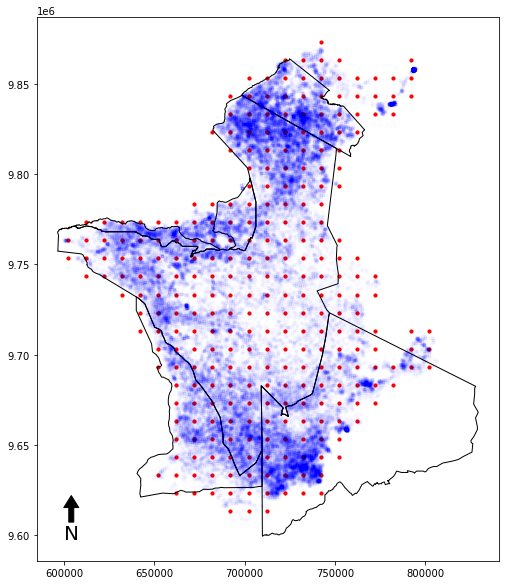

290

In [12]:

# Set up the grid - previous code
offset = 1#50
gridwidth = 10 # width in step lengths
xmin = gridwidth*(((x.min()-offset)//gridwidth))
xmax = gridwidth*(((x.max()+offset)//gridwidth)+2)

ymin = gridwidth*(((y.min()-offset)//gridwidth))
ymax = gridwidth*(((y.max()+offset)//gridwidth)+2)

gridx = np.arange(xmin,xmax,gridwidth)
gridy = np.arange(ymin,ymax,gridwidth)

H, yedges, xedges = np.histogram2d(y, x,bins=[gridy,gridx])

xedges = 0.5*(xedges[1:]+xedges[:-1])
yedges = 0.5*(yedges[1:]+yedges[:-1])

xx, yy = np.meshgrid(xedges, yedges, sparse=False)

# only keep if a wildebeest has been in the cell or a neighbouring cell
H = maximum_filter(H, size=1)


xx = xx[H>1]
yy = yy[H>1]


x_grid = np.array([xx.flatten(), yy.flatten()])
x_grid = x_grid.T

num_inducing_points_ = x_grid.shape[0]


np.random.shuffle(x_grid)

#x_grid += np.random.normal(scale=0.1*gridwidth,size=x_grid.shape)
num_inducing_points_

x_grid.shape
plt.figure(figsize=(10,10))
ax = plt.subplot()

dfpark = gpd.read_file("../data/wildebeest_data/v4_serengeti_ecosystem.shp")

dfpark[dfpark.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=ax,color='black',linewidth=1)#, edgecolor='black')


ax.set_aspect('equal')
xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
ax.annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)


plt.plot((x+xmean)*dist_factor,(y+ymean)*dist_factor,'.',c='b',alpha=0.01)
plt.scatter((x_grid[:,0]+xmean)*dist_factor,(x_grid[:,1]+ymean)*dist_factor,s=10,c='r')
plt.show()

num_inducing_points_

,AID,x,y,Date,migrant,SPECIES,COLLAR_ID,OWNER,SEX,year,...,Edge,Village_Dist,Tourism_fpt,Rangerpost_Dist,Temp,NDVI,Temp_8day,Nitrogen,D_drainage,ID
17988,W27,654992.2097,9759749.123,6/9/2013 6:30,1,WB,T5H-2175,HOPCRAFT,F,2013,...,0.124279,14153.179690,0.056567,2.906835,22.348169,0.3195,32.83,0.840710,2.640999,0
17989,W27,648456.1466,9762994.705,6/9/2013 18:00,1,WB,T5H-2175,HOPCRAFT,F,2013,...,1.003460,14519.379880,0.036662,8.616692,23.249017,0.3244,34.79,0.820383,1.611796,0
17990,W27,646249.6810,9763062.731,6/10/2013 6:30,1,WB,T5H-2175,HOPCRAFT,F,2013,...,2.102973,14577.379880,0.031140,10.733989,23.328470,0.3302,33.43,0.839792,0.403321,0
17991,W27,639932.1047,9766920.441,6/10/2013 18:01,1,WB,T5H-2175,HOPCRAFT,F,2013,...,0.790269,13050.379880,0.018909,6.762931,24.326074,0.2876,34.17,0.834002,0.897052,0
17992,W27,638311.3819,9767424.449,6/11/2013 6:30,1,WB,T5H-2175,HOPCRAFT,F,2013,...,0.719645,13793.110350,0.017756,6.309243,22.310251,0.3051,33.83,0.845218,0.897052,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234493,W87,689078.2869,9756332.317,6/2/2019 2:30,1,WB,T5H-6663,HOPCRAFT,M,2019,...,1.722043,6250.000000,0.026274,3.321243,17.810464,0.3021,32.35,0.682238,1.612673,41
234494,W87,690375.3396,9756205.652,6/2/2019 6:30,1,WB,T5H-6663,HOPCRAFT,M,2019,...,1.722293,6708.204102,0.024597,2.481872,22.890482,0.3656,30.23,0.706873,2.423886,41
234495,W87,691521.6221,9753273.028,6/2/2019 10:30,1,WB,T5H-6663,HOPCRAFT,M,2019,...,4.735965,9953.014648,0.026027,4.974600,27.844232,0.3292,30.51,0.754471,0.968750,41
234496,W87,690937.0943,9752645.166,6/2/2019 18:30,1,WB,T5H-6663,HOPCRAFT,M,2019,...,5.306270,10446.290040,0.027378,5.660530,21.929941,0.3830,29.65,0.754471,0.968750,41


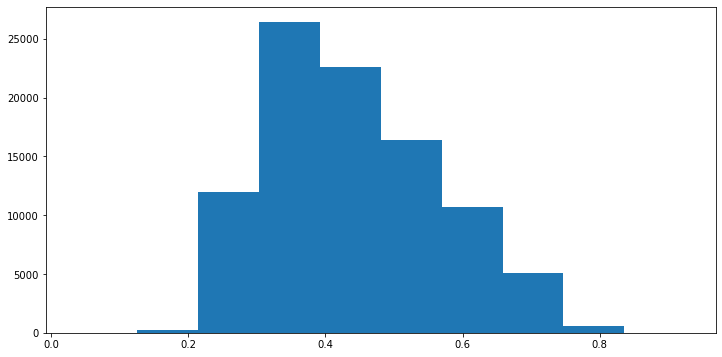

In [13]:
plt.hist(df.NDVI.values)
df

In [74]:
# # add distance to seronera as excluded from village dist metric
# df['Seronera'] = (((df['x'].values-702639.765)**2+(df['y'].values-9730629.191)**2)**0.5)#/1000
# #df['Naabi'] = (((df['x'].values-721909.102)**2+(df['y'].values-9686563.760)**2)**0.5)/1000
df['D_drainage']=np.log(df['D_drainage'].values)


In [75]:
# df.D_drainage.min()

In [76]:
#predictor = np.min(df['Village_Dist'].values[...,None]/1000,df['Rangerpost_Dist'].values[...,None]/1000)
#df['Village_Dist2'] = df[['Village_Dist','Seronera']].min(axis=1)
#predictor = df[['Rangerpost_Dist','Village_Dist2','Seronera','Naabi']].min(axis=1).values[...,None]

#min(df['Village_Dist'],df['Rangerpost_Dist'])

#predictor = df[['Rangerpost_Dist','Rangerpost_Dist']].min(axis=1).values[...,None]
#predictor = df[['Rangerpost_Dist','Village_Dist2','Seronera','Naabi']].min(axis=1).values[...,None]
predictor = df[['Nitrogen','NDVI','D_drainage']].values#[...,None]
predictor = (predictor - predictor.mean(axis=0))
predictor = (predictor/predictor.std(axis=0))


num_covar = predictor.shape[-1]
num_covar

3

In [77]:
df.D_drainage.max()

2.6137951805673296

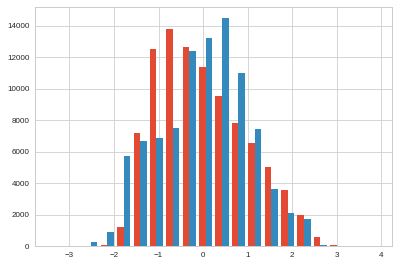

In [78]:
plt.hist(predictor[:,1:],bins=20)
plt.show()

In [18]:
# indices = np.random.choice(X.shape[0], 500, replace=False)
# x_grid=X[indices].copy()

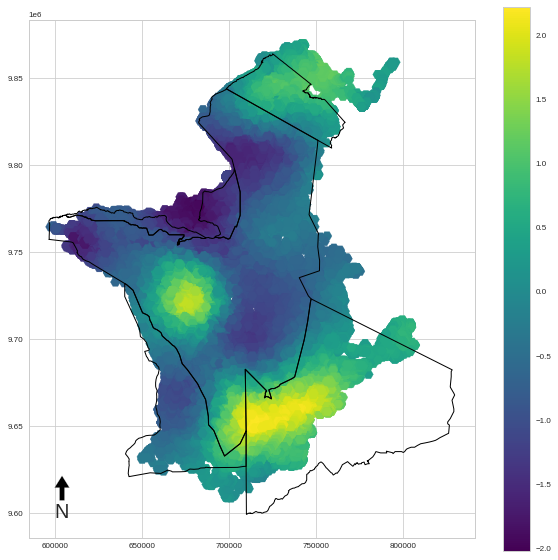

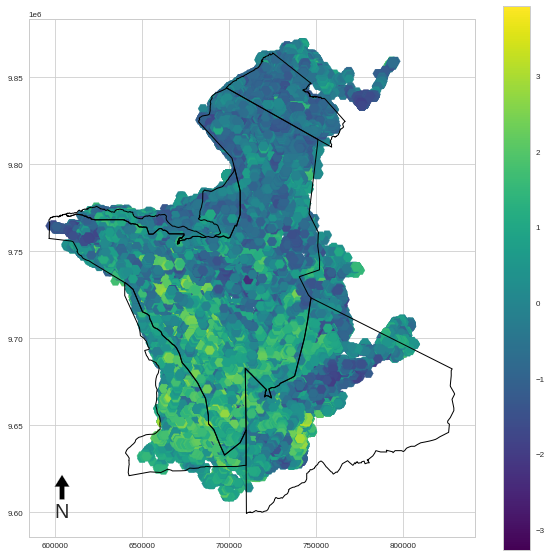

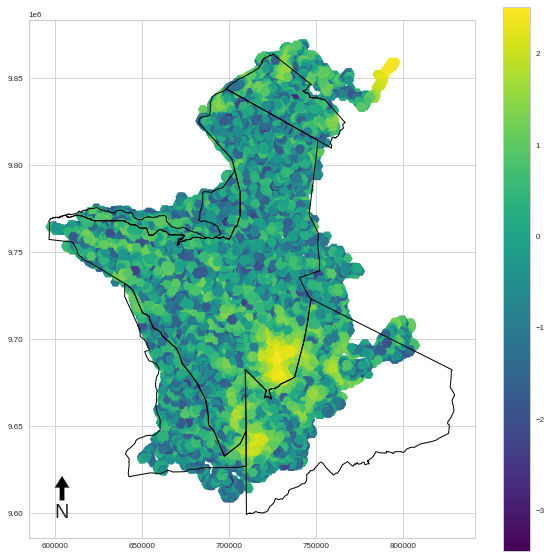

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [79]:
plt.figure(figsize=(10,10))
ax = plt.subplot()
dfpark[dfpark.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=ax,color='black',linewidth=1)#, edgecolor='black')


ax.set_aspect('equal')
xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
ax.annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)


#plt.plot((x+xmean)*1000,(y+ymean)*1000,'.',c='b',alpha=predictor[:,0])
#plt.scatter((x_grid[:,0]+xmean)*1000,(x_grid[:,1]+ymean)*1000,s=1,c='r')

plt.scatter((x+xmean)*1000,(y+ymean)*1000,c=predictor[:,0],cmap='viridis',marker='H',s=100)#vmin,vmax
plt.colorbar()
plt.show()
plt.figure(figsize=(10,10))
ax = plt.subplot()
dfpark[dfpark.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=ax,color='black',linewidth=1)#, edgecolor='black')


ax.set_aspect('equal')
xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
ax.annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)


#plt.plot((x+xmean)*1000,(y+ymean)*1000,'.',c='b',alpha=predictor[:,0])
#plt.scatter((x_grid[:,0]+xmean)*1000,(x_grid[:,1]+ymean)*1000,s=1,c='r')

plt.scatter((x+xmean)*1000,(y+ymean)*1000,c=predictor[:,1],cmap='viridis',marker='H',s=100)#vmin,vmax
plt.colorbar()
plt.show()


plt.figure(figsize=(10,10))
ax = plt.subplot()
dfpark[dfpark.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=ax,color='black',linewidth=1)#, edgecolor='black')


ax.set_aspect('equal')
xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
ax.annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)


#plt.plot((x+xmean)*1000,(y+ymean)*1000,'.',c='b',alpha=predictor[:,0])
#plt.scatter((x_grid[:,0]+xmean)*1000,(x_grid[:,1]+ymean)*1000,s=1,c='r')

plt.scatter((x+xmean)*1000,(y+ymean)*1000,c=predictor[:,2],cmap='viridis',marker='H',s=100)#vmin,vmax
plt.colorbar()
plt.show()
plt.figure(figsize=(10,10))

In [80]:
# create the dataset

BATCH_SIZE=4
SEG_LENGTH=500

allT = []
allX = []
allP = []
for i in np.unique(ID):
    if T[ID == i].shape[0]<SEG_LENGTH:
        continue
    allT.append(T[ID == i])
    allX.append(X[ID == i])
    allP.append(predictor[ID == i])


num_training_points_ = 0
for tt in allT:
    num_training_points_+=(tt.shape[0]//SEG_LENGTH)*SEG_LENGTH
print('..',num_training_points_,'..')

.. 85000 ..


In [81]:

    

class segment_generator:
    def __iter__(self):
        
        # loop over individuals
        self.i = 0
        self.max_i = len(allT)
        
        # loop over segments
        self.j = 0
        #self.max_j = num_training_points_//(self.max_i*SEG_LENGTH)
        
        
        
        return self

    def __next__(self):
        
        if self.i == self.max_i:
            raise StopIteration
                
        T = allT[self.i]
        X = allX[self.i] 

        
        P = allP[self.i] 

        TT = T[self.j*SEG_LENGTH:(self.j+1)*SEG_LENGTH]
        XX = X[self.j*SEG_LENGTH:(self.j+1)*SEG_LENGTH]
        PP = P[self.j*SEG_LENGTH:(self.j+1)*SEG_LENGTH]

    
        self.j += 1
        
        if (self.j+1)*SEG_LENGTH > T.shape[0]:
            self.i+=1
            self.j=0

        return TT,XX,0.5*(PP[:-1]+PP[1:])
    
dataset = tf.data.Dataset.from_generator(segment_generator, (tf.float64,tf.float64,tf.float64),output_shapes=(tf.TensorShape([None,1]),tf.TensorShape([None,2]),tf.TensorShape([None,num_covar]))) 
dataset = dataset.shuffle(1000)
dataset = dataset.batch(BATCH_SIZE)

options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
dataset = dataset.with_options(options)


In [82]:
for d in dataset:
    #print(d[0].shape,d[1].shape,d[2].shape)
    print(d[2].shape[-1])
    break

3


In [83]:
# ## set up the kernels and model

# kernel_len_a = tfp.util.TransformedVariable(0.5,tfb.Softplus(),dtype=tf.float64, name='k_len_a',trainable=True)
# kernel_len_l = tfp.util.TransformedVariable(20.,tfb.Chain([tfb.Shift(np.float64(5.0)),tfb.Softplus()]),dtype=tf.float64, name='k_len_l',trainable=True)

# # amplitude kernel parameters, lower levels
# kernel_amp_a = tfp.util.TransformedVariable(0.5,tfb.Softplus(), dtype=tf.float64, name='k_amp_a',trainable=True)
# kernel_amp_l = tfp.util.TransformedVariable(20.,tfb.Chain([tfb.Shift(np.float64(5.0)),tfb.Softplus()]), dtype=tf.float64, name='k_amp_l',trainable=True)

#     #kernels on the second layer
# kernel_len = tfk.ExponentiatedQuadratic(kernel_len_a,kernel_len_l)
# kernel_amp = tfk.ExponentiatedQuadratic(kernel_amp_a,kernel_amp_l)

# vgp = nsgpVI(kernel_len,kernel_amp,n_inducing_points=num_inducing_points_,inducing_index_points=Z,dataset=dataset,num_training_points=num_training_points_, num_sequential_samples=5,num_parallel_samples=20,init_observation_noise_variance=1e-3)  

In [84]:
# in case we need to reload
importlib.reload(nsgp_vi_covar)
from nsgp_vi_covar import nsgpVI

In [85]:
kernel_len_a = tfp.util.TransformedVariable(1,tfb.Softplus(), dtype=tf.float64, name='k_len_a',trainable=1)
kernel_amp_a = tfp.util.TransformedVariable(1,tfb.Softplus(), dtype=tf.float64, name='k_amp_a',trainable=1)

# kernel_amp_l = tfp.util.TransformedVariable(20.0,tfb.Chain([tfb.Shift(np.float64(5.05)),tfb.Softplus()]), dtype=tf.float64, name='k_amp_l',trainable=1)
# kernel_len_l = tfp.util.TransformedVariable(20.0,tfb.Chain([tfb.Shift(np.float64(5.05)),tfb.Softplus()]), dtype=tf.float64, name='k_len_l',trainable=1)
kernel_amp_l = tfp.util.TransformedVariable(15.0,tfb.Chain([tfb.Scale(np.float64(10.0)),tfb.Shift(np.float64(1.)),tfb.Softplus()]), dtype=tf.float64, name='k_amp_l',trainable=1)
kernel_len_l = tfp.util.TransformedVariable(15.0,tfb.Chain([tfb.Scale(np.float64(10.0)),tfb.Shift(np.float64(1.)),tfb.Softplus()]), dtype=tf.float64, name='k_len_l',trainable=1)

#kernels on the lower layer
kernel_len = tfk.ExponentiatedQuadratic(kernel_len_a,kernel_len_l)
kernel_amp = tfk.ExponentiatedQuadratic(kernel_amp_a,kernel_amp_l)

init_observation_noise_variance = 1e-5 # corresponds to a 3m s.d.
untransformed_obs_noise = np.log(np.exp(init_observation_noise_variance)-1) 

obs_noise_prior = tfp.distributions.Normal(loc=np.float64(untransformed_obs_noise),scale=np.float64(1.0))

# parameters of normal priors on the covariate coefficients
prior_beta_len_means = np.zeros(num_covar,dtype=np.float64)
prior_beta_amp_means = np.zeros(num_covar,dtype=np.float64)
prior_beta_len_std = 10.*np.ones(num_covar,dtype=np.float64)
prior_beta_amp_std = 10.*np.ones(num_covar,dtype=np.float64)

vgp = nsgpVI(kernel_len,kernel_amp,n_inducing_points=num_inducing_points_,
             inducing_index_points=x_grid,dataset=dataset,num_training_points=num_training_points_, 
             num_covars = num_covar,prior_beta_len_means=prior_beta_len_means,prior_beta_amp_means=prior_beta_amp_means,
             prior_beta_len_std=prior_beta_len_std,prior_beta_amp_std=prior_beta_amp_std, segment_length = SEG_LENGTH,
             num_sequential_samples=1,num_parallel_samples=32,init_observation_noise_variance=untransformed_obs_noise,
             obs_noise_prior=None,jitter=1e-8) 

# vgp = nsgpVI(kernel_len,kernel_amp,n_inducing_points=num_inducing_points_,
#              inducing_index_points=x_grid,dataset=dataset,num_training_points=num_training_points_, 
#              segment_length = SEG_LENGTH,
#              num_sequential_samples=1,num_parallel_samples=32,init_observation_noise_variance=untransformed_obs_noise,
#              obs_noise_prior=obs_noise_prior,jitter=1e-8) 


In [86]:
NUM_EPOCHS=200
loss = vgp.optimize(BATCH_SIZE, NUM_EPOCHS=NUM_EPOCHS)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Loss 1736.681661, klen_l 22.867448, kamp_l 16.313606, obs 0.000722: 100%|██████████| 200/200 [42:45<00:00, 12.83s/it]


In [87]:
vgp.mean_amp

<tf.Variable 'var_mean:0' shape=(1,) dtype=float64, numpy=array([-1.65837723])>

In [88]:
tf.math.softplus(-4.6)**0.5

<tf.Tensor: shape=(), dtype=float32, numpy=0.100008264>

In [89]:
(0.6**0.5)*1000

#vgp.vgp_observation_noise_variance

774.5966692414834

In [90]:
# vgp.obs_noise_prior.log_prob(-1.)


In [91]:
# locations=d[1]
# #prior_len_means
# num_covar
untransformed_obs_noise

-11.512920464975764

In [92]:
# S=3
# NUM_LATENT=2
# midpoints = 0.5*(locations[:,:-1]+locations[:,1:])
# mean, var = vgp.get_conditional(midpoints)
# samples = vgp.sample_conditional(mean, var, S)
    
# len_samples,amp_samples = tf.split(samples,NUM_LATENT,axis=2)
        
# # tf.math.exp(self.mean_len + self.beta_len*predictor_values + len_samples), \
# #                 tf.math.exp(self.mean_amp + self.beta_amp*predictor_values + amp_samples)
# B = tf.shape(mean)[0]
# N = tf.shape(mean)[1]
# z = tf.random.normal((S,B,vgp.num_covars),dtype=tf.float64)
# zlen = tf.expand_dims(tf.reshape(vgp.beta_len_mean,(1,1,-1)) + (tf.reshape(vgp.beta_len_std,(1,1,-1))*z),-1)
# scaled_predictors_len = tf.linalg.matmul(tf.expand_dims(predictor_values,0),zlen)
# #         I = self.jitter**1 * tf.eye(N, dtype=tf.float64) #NN
# #         chol = tf.linalg.cholesky(var + I)  # BNN
# tf.math.exp(vgp.mean_len + scaled_predictors_len + len_samples)

In [93]:
# tf.expand_dims(zlen,-1).shape

In [94]:
# vgp.beta_amp_std

In [95]:
# (tf.reshape(vgp.beta_len_std,(1,1,-1))*z)
# prior = tfp.distributions.Normal(loc=[np.float64(0),0],scale=[10,1])

In [96]:
# tfp.distributions.Normal(loc=vgp.beta_amp_mean,scale=vgp.beta_amp_std).sample()

In [97]:
# tfp.distributions.kl_divergence(tfp.distributions.Normal(loc=vgp.beta_amp_mean,scale=vgp.beta_amp_std),prior)

In [98]:
vgp.vgp_observation_noise_variance

<tf.Variable 'nv:0' shape=() dtype=float64, numpy=-7.2334239399532265>

## Plotting

In [99]:

import matplotlib.ticker as tick
plt.style.use('ggplot') 
plt.style.use('seaborn-paper') 
plt.style.use('seaborn-whitegrid') 

from matplotlib_scalebar.scalebar import ScaleBar
from shapely.geometry import Polygon

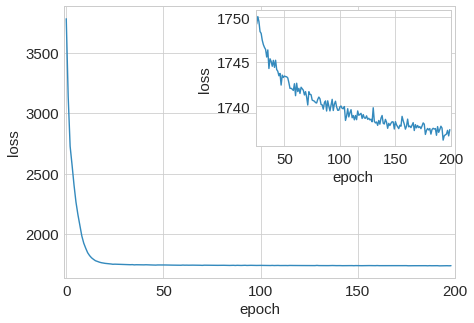

In [100]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig, ax0 = plt.subplots(1, 1, figsize=(7,5))#,gridspec_kw={'width_ratios': [1,1,1.5]})
ax0.plot(loss[1:],'-',c='C1')



ax0.set_xlabel('epoch',size=15)
ax0.set_ylabel('loss',size=15)
ax0.tick_params(axis='both', which='major', labelsize=15)
ax0.set_xlim(-1,NUM_EPOCHS)

ax1 = inset_axes(ax0, width="50%", height="50%", loc=1)
ax1.plot(np.arange(25,NUM_EPOCHS),loss[25:],'-',c='C1')


ax1.set_xlabel('epoch',size=15)
ax1.set_ylabel('loss',size=15)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_xlim(24,NUM_EPOCHS)


plt.savefig("serengeti_training_loss_covars.png",dpi=300)

plt.show()

In [101]:

# dense grid for plotting
offset = 0
gridwidth = 2 # width in kilometres
xmin = gridwidth*(((x.min()-offset)//gridwidth))
xmax = gridwidth*(((x.max()+offset)//gridwidth)+2)
ymin = gridwidth*(((y.min()-offset)//gridwidth))
ymax = gridwidth*(((y.max()+offset)//gridwidth)+2)

gridx = np.arange(xmin,xmax,gridwidth)
gridy = np.arange(ymin,ymax,gridwidth)

H, yedges, xedges = np.histogram2d(y, x,bins=[gridy,gridx])

xedges = 0.5*(xedges[1:]+xedges[:-1])
yedges = 0.5*(yedges[1:]+yedges[:-1])

xx, yy = np.meshgrid(xedges, yedges, sparse=False)

# only keep if a wildebeest has been in the cell
H = maximum_filter(H, size=1)

xx = xx[H>0]
yy = yy[H>0]

px_grid = np.array([xx.flatten(), yy.flatten()])
px_grid = px_grid




In [102]:
grid_predictors = np.zeros((px_grid.shape[1],num_covar))
grid_predictors[:,0]=1
predictor_values = grid_predictors[None]

locations = px_grid.T[None]
S = 1000


In [103]:

mean, var = vgp.get_conditional(locations)
samples = vgp.sample_conditional(mean, var, S)
len_samples,amp_samples = tf.split(samples,2,axis=2)
# covariate samples
B = tf.shape(mean)[0]

z = tf.random.normal((S,B,vgp.num_covars),dtype=tf.float64)
zlen = tf.expand_dims(tf.reshape(vgp.beta_len_mean,(1,1,-1)) + (tf.reshape(vgp.beta_len_std,(1,1,-1))*z),-1)
scaled_predictors_len = tf.linalg.matmul(tf.expand_dims(predictor_values,0),zlen)

z = tf.random.normal((S,B,vgp.num_covars),dtype=tf.float64)
zamp = tf.expand_dims(tf.reshape(vgp.beta_amp_mean,(1,1,-1)) + (tf.reshape(vgp.beta_amp_std,(1,1,-1))*z),-1)
scaled_predictors_amp = tf.linalg.matmul(tf.expand_dims(predictor_values,0),zamp)

len_samples = tf.math.exp(vgp.mean_len +  len_samples)
var_samples = tf.math.exp(vgp.mean_amp +  amp_samples)

In [104]:
len_samples = len_samples.numpy()[:,0]
std_samples = var_samples.numpy()[:,0]**0.5

In [105]:
len_samples.shape

(1000, 5640, 1)

In [106]:
mean_len = np.mean(len_samples,axis = 0)[:, np.newaxis]
std_len = np.std(len_samples,axis = 0)[:, np.newaxis]
mean_std = np.mean(std_samples,axis = 0)[:, np.newaxis]
std_std= np.std(std_samples,axis = 0)[:, np.newaxis]


In [107]:
std_q_25 = np.percentile(std_samples,2.5,axis=0)[:, np.newaxis]
std_q_975 = np.percentile(std_samples,97.5,axis=0)[:, np.newaxis]

len_q_25 = np.percentile(len_samples,2.5,axis=0)[:, np.newaxis]
len_q_975 = np.percentile(len_samples,97.5,axis=0)[:, np.newaxis]

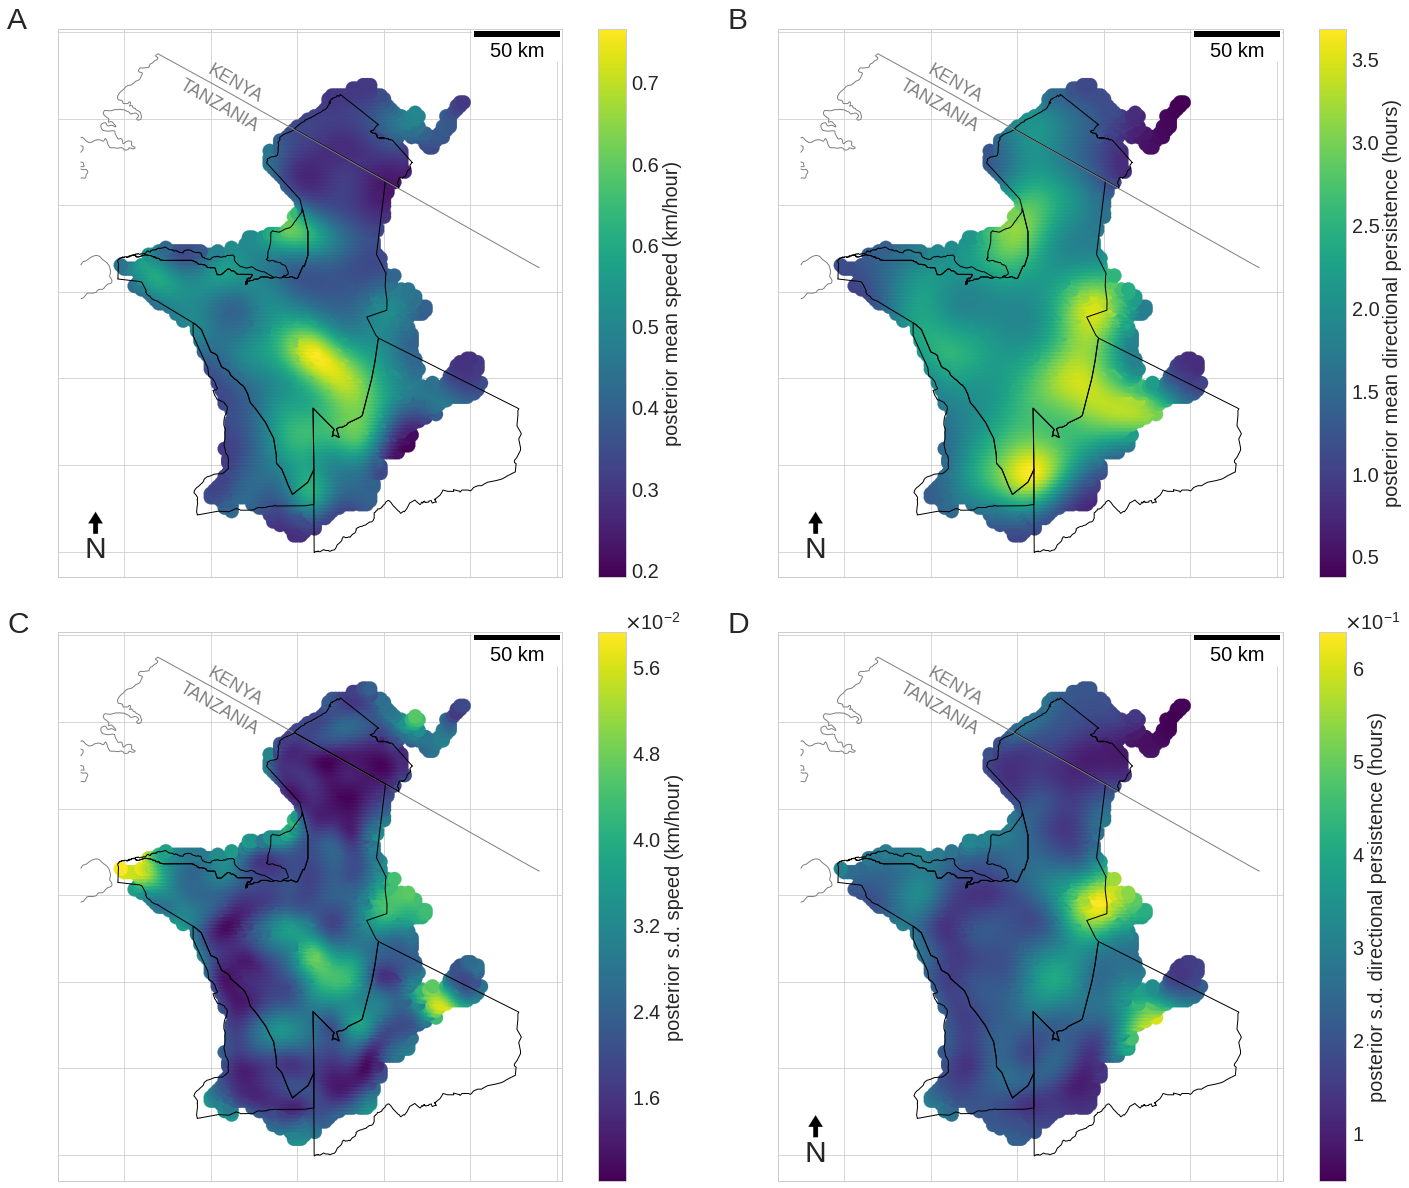

In [108]:
# 2x2 design len and var 

dfborder=gpd.read_file("../data/wildebeest_data/v4_serengeti_ecosystem.shp")
dfTZ=gpd.read_file('../data/wildebeest_data/TZ_border_UTM36S.shp')


dfTZ=  dfTZ.to_crs(dfborder.crs)
polygon = Polygon([[5.75e5,9.6e6], [8.4e5,9.6e6], [8.4e5,9.95e6], [5.75e5,9.95e6], [5.75e5,9.6e6]])
poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=dfborder.crs)
dfTZ = gpd.clip(dfTZ, poly_gdf)
dfTZ = dfTZ.translate(0, 1000)
fig, axs = plt.subplots(2, 2, figsize=(40,20))

#mean_var
dfborder[dfborder.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=axs[0,0],color='black',linewidth=1)
dfTZ.plot(ax=axs[0,0],color='gray',linewidth=1)
axs[0, 0].set_aspect('equal')
axs[0, 0].add_artist(ScaleBar(1,font_properties = {"size": 20}))
xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
axs[0, 0].annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=30,
            xycoords=axs[0,0].transAxes)
axs[0, 0].text(0.35, 0.9, "KENYA", ha="center", va="center", rotation=-30, size=18, color='gray', transform=axs[0,0].transAxes)
axs[0, 0].text(0.320, 0.86, "TANZANIA", ha="center", va="center", rotation=-30, size=18, color='gray',transform=axs[0,0].transAxes)
ax00 = axs[0, 0].scatter((px_grid[0]+xmean)*1000,(px_grid[1]+ymean)*1000,c=mean_std,cmap='viridis',marker='o',s=200)#,vmax=20)#vmin,vmax
#axs[0,0].set_title('A',loc='left',size=30,pad=100)
axs[0,0].text(-0.1,1,'A', size=30, transform=axs[0, 0].transAxes)
axs[0,0].tick_params( labelleft=False, labelbottom=False) 
cbar = fig.colorbar(ax00, ax=axs[0, 0],format=tick.FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=20) 
cbar.set_label(label='posterior mean speed (km/hour)',size=20)
tick_locator = tick.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()

#std_var
dfborder[dfborder.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=axs[0,1],color='black',linewidth=1)
dfTZ.plot(ax=axs[1,0],color='gray',linewidth=1)
axs[1, 0].set_aspect('equal')
axs[1, 0].add_artist(ScaleBar(1,font_properties = {"size": 20}))
xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
axs[1, 0].annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=30,
            xycoords=axs[0,1].transAxes)
axs[1, 0].text(0.35, 0.9, "KENYA", ha="center", va="center", rotation=-30, size=18, color='gray', transform=axs[1,0].transAxes)
axs[1, 0].text(0.320, 0.86, "TANZANIA", ha="center", va="center", rotation=-30, size=18, color='gray',transform=axs[1,0].transAxes)
ax10 = axs[1, 0].scatter((px_grid[0]+xmean)*1000,(px_grid[1]+ymean)*1000,c=std_std,cmap='viridis',marker='o',s=200)#,vmax=2)#vmin,vmax
#axs[1,0].set_title('C',loc='center',size=30)
axs[1,0].text(-0.1,1,'C', size=30, transform=axs[1, 0].transAxes)

axs[1,0].tick_params( labelleft=False, labelbottom=False) 
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
cbar = fig.colorbar(ax10, ax=axs[1, 0],format=formatter)
# cbar = fig.colorbar(ax01, ax=axs[1, 0],format=tick.FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=20) 
cbar.ax.yaxis.offsetText.set_fontsize(20)
cbar.ax.yaxis.offsetText.set_x(3)
cbar.set_label(label='posterior s.d. speed (km/hour)',size=20)
tick_locator = tick.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()

#mean_len
dfborder[dfborder.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=axs[1,0],color='black',linewidth=1)
dfTZ.plot(ax=axs[0,1],color='gray',linewidth=1)
axs[0, 1].set_aspect('equal')
axs[0, 1].add_artist(ScaleBar(1,font_properties = {"size": 20}))
xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
axs[0, 1].annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=30,
            xycoords=axs[1,0].transAxes)
axs[0,1].text(0.35, 0.9, "KENYA", ha="center", va="center", rotation=-30, size=18, color='gray', transform=axs[0,1].transAxes)
axs[0,1].text(0.320, 0.86, "TANZANIA", ha="center", va="center", rotation=-30, size=18, color='gray',transform=axs[0,1].transAxes)
ax01= axs[0, 1].scatter((px_grid[0]+xmean)*1000,(px_grid[1]+ymean)*1000,c=mean_len,cmap='viridis',marker='o',s=200)#vmin,vmax

axs[0,1].text(-0.1,1,'B', size=30, transform=axs[0, 1].transAxes)

axs[0,1].tick_params( labelleft=False, labelbottom=False) 
cbar = fig.colorbar(ax01, ax=axs[0, 1],format=tick.FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=20) 
cbar.set_label(label='posterior mean directional persistence (hours)',size=20)
tick_locator = tick.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()

#std_len
dfborder[dfborder.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=axs[1,1],color='black',linewidth=1)
dfTZ.plot(ax=axs[1,1],color='gray',linewidth=1)
axs[1, 1].set_aspect('equal')
axs[1, 1].add_artist(ScaleBar(1,font_properties = {"size": 20}))
xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
axs[1, 1].annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=30,
            xycoords=axs[1,1].transAxes)
axs[1, 1].text(0.35, 0.9, "KENYA", ha="center", va="center", rotation=-30, size=18, color='gray', transform=axs[1,1].transAxes)
axs[1, 1].text(0.320, 0.86, "TANZANIA", ha="center", va="center", rotation=-30, size=18, color='gray',transform=axs[1,1].transAxes)
ax11 = axs[1, 1].scatter((px_grid[0]+xmean)*1000,(px_grid[1]+ymean)*1000,c=std_len,cmap='viridis',marker='o',s=200)#,vmax=0.02,vmin=0)#vmin,vmax

axs[1,1].text(-0.1,1,'D', size=30, transform=axs[1, 1].transAxes)

axs[1,1].tick_params( labelleft=False, labelbottom=False) 
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
cbar = fig.colorbar(ax11, ax=axs[1, 1],format=formatter)
cbar.set_label(label='posterior s.d. directional persistence (hours)',size=20)

cbar.ax.tick_params(labelsize=20) 
cbar.ax.yaxis.offsetText.set_fontsize(20)
cbar.ax.yaxis.offsetText.set_x(3)

tick_locator = tick.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()



plt.tick_params( labelleft=False, labelbottom=False) 
plt.subplots_adjust(left=0.2,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.9, 
                    wspace=0.0001, 
                    hspace=0.1)


plt.savefig("serengeti_spatial_covars.png",bbox_inches='tight',dpi=300)
plt.show()


In [109]:


# # 2x2 design len and var 


# fig, axs = plt.subplots(2, 2, figsize=(40,20))

# #std q25
# dfborder[dfborder.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=axs[0,0],color='black',linewidth=1)
# dfTZ.plot(ax=axs[0,0],color='gray',linewidth=1)
# axs[0, 0].set_aspect('equal')
# axs[0, 0].add_artist(ScaleBar(1,font_properties = {"size": 20}))
# xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
# axs[0, 0].annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
#             arrowprops=dict(facecolor='black', width=5, headwidth=15),
#             ha='center', va='center', fontsize=30,
#             xycoords=axs[0,0].transAxes)
# axs[0, 0].text(0.35, 0.9, "KENYA", ha="center", va="center", rotation=-30, size=18, color='gray', transform=axs[0,0].transAxes)
# axs[0, 0].text(0.320, 0.86, "TANZANIA", ha="center", va="center", rotation=-30, size=18, color='gray',transform=axs[0,0].transAxes)
# ax00 = axs[0, 0].scatter((px_grid[0]+xmean)*1000,(px_grid[1]+ymean)*1000,c=std_q_25,cmap='viridis',marker='o',s=200,vmin=0.25,vmax=0.75)#,vmax=25)#vmin,vmax
# #axs[0,0].set_title('A',loc='center',size=30)
# axs[0,0].text(-0.1,1,'A', size=30, transform=axs[0, 0].transAxes)

# axs[0,0].tick_params( labelleft=False, labelbottom=False) 
# cbar = fig.colorbar(ax00, ax=axs[0, 0],format=tick.FormatStrFormatter('%.2f'))
# cbar.ax.tick_params(labelsize=20) 
# cbar.set_label(label='speed 95% LCI',size=20)

# tick_locator = tick.MaxNLocator(nbins=7)
# cbar.locator = tick_locator
# cbar.update_ticks()

# #std q975
# dfborder[dfborder.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=axs[1,0],color='black',linewidth=1)
# dfTZ.plot(ax=axs[0,1],color='gray',linewidth=1)
# axs[0, 1].set_aspect('equal')
# axs[0, 1].add_artist(ScaleBar(1,font_properties = {"size": 20}))
# xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
# axs[0, 1].annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
#             arrowprops=dict(facecolor='black', width=5, headwidth=15),
#             ha='center', va='center', fontsize=30,
#             xycoords=axs[1,0].transAxes)
# axs[0,1].text(0.35, 0.9, "KENYA", ha="center", va="center", rotation=-30, size=18, color='gray', transform=axs[0,1].transAxes)
# axs[0,1].text(0.320, 0.86, "TANZANIA", ha="center", va="center", rotation=-30, size=18, color='gray',transform=axs[0,1].transAxes)
# ax10= axs[0, 1].scatter((px_grid[0]+xmean)*1000,(px_grid[1]+ymean)*1000,c=std_q_975,cmap='viridis',marker='o',s=200,vmin=0.25,vmax=0.75)#,vmax=25)#vmin,vmax
# #axs[0,1].set_title('B',loc='center',size=30)
# axs[0,1].text(-0.1,1,'B', size=30, transform=axs[0, 1].transAxes)

# axs[0,1].tick_params( labelleft=False, labelbottom=False) 
# cbar = fig.colorbar(ax10, ax=axs[0, 1],format=tick.FormatStrFormatter('%.2f'))
# cbar.ax.tick_params(labelsize=20) 
# cbar.set_label(label='speed 95% UCI',size=20)
# tick_locator = tick.MaxNLocator(nbins=7)
# cbar.locator = tick_locator
# cbar.update_ticks()
# #len q25

# dfborder[dfborder.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=axs[0,1],color='black',linewidth=1)
# dfTZ.plot(ax=axs[1,0],color='gray',linewidth=1)
# axs[1, 0].set_aspect('equal')
# axs[1, 0].add_artist(ScaleBar(1,font_properties = {"size": 20}))
# xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
# axs[1, 0].annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
#             arrowprops=dict(facecolor='black', width=5, headwidth=15),
#             ha='center', va='center', fontsize=30,
#             xycoords=axs[0,1].transAxes)
# axs[1, 0].text(0.35, 0.9, "KENYA", ha="center", va="center", rotation=-30, size=18, color='gray', transform=axs[1,0].transAxes)
# axs[1, 0].text(0.320, 0.86, "TANZANIA", ha="center", va="center", rotation=-30, size=18, color='gray',transform=axs[1,0].transAxes)
# ax01 = axs[1, 0].scatter((px_grid[0]+xmean)*1000,(px_grid[1]+ymean)*1000,c=len_q_25,cmap='viridis',marker='o',s=200,vmin=0.8,vmax=3.6)#vmin,vmax
# #axs[1,0].set_title('C',loc='center',size=30)
# axs[1,0].text(-0.1,1,'C', size=30, transform=axs[1,0].transAxes)

# axs[1,0].tick_params( labelleft=False, labelbottom=False) 
# cbar = fig.colorbar(ax01, ax=axs[1, 0],format=tick.FormatStrFormatter('%.2f'))
# cbar.ax.tick_params(labelsize=20) 
# cbar.set_label(label='directional persistence 95% LCI',size=20)
# tick_locator = tick.MaxNLocator(nbins=7)
# cbar.locator = tick_locator
# cbar.update_ticks()


# #len q97.5
# dfborder[dfborder.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=axs[1,1],color='black',linewidth=1)
# dfTZ.plot(ax=axs[1,1],color='gray',linewidth=1)
# axs[1, 1].set_aspect('equal')
# axs[1, 1].add_artist(ScaleBar(1,font_properties = {"size": 20}))
# xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
# axs[1, 1].annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
#             arrowprops=dict(facecolor='black', width=5, headwidth=15),
#             ha='center', va='center', fontsize=30,
#             xycoords=axs[1,1].transAxes)
# axs[1, 1].text(0.35, 0.9, "KENYA", ha="center", va="center", rotation=-30, size=18, color='gray', transform=axs[1,1].transAxes)
# axs[1, 1].text(0.320, 0.86, "TANZANIA", ha="center", va="center", rotation=-30, size=18, color='gray',transform=axs[1,1].transAxes)
# ax11 = axs[1, 1].scatter((px_grid[0]+xmean)*1000,(px_grid[1]+ymean)*1000,c=len_q_975,cmap='viridis',marker='o',s=200,vmin=0.8,vmax=3.6)#vmin,vmax
# #axs[1,1].set_title('D',loc='center',size=30)
# axs[1,1].text(-0.1,1,'D', size=30, transform=axs[1, 1].transAxes)

# axs[1,1].tick_params( labelleft=False, labelbottom=False) 
# cbar = fig.colorbar(ax11, ax=axs[1, 1],format=tick.FormatStrFormatter('%.2f'))
# cbar.set_label(label='directinal persistence 95% UCI',size=20)
# cbar.ax.tick_params(labelsize=20) 
# tick_locator = tick.MaxNLocator(nbins=7)
# cbar.locator = tick_locator
# cbar.update_ticks()



# plt.tick_params( labelleft=False, labelbottom=False) 
# plt.subplots_adjust(left=0.2,
#                     bottom=0.1, 
#                     right=0.7, 
#                     top=0.9, 
#                     wspace=0.0001, 
#                     hspace=0.1)




# plt.savefig("serengeti_quantiles.png",bbox_inches='tight',dpi=300)

# plt.show()


In [110]:

# # dense grid for plotting
# offset = 10
# gridwidth = 2 # width in kilometres
# xmin = gridwidth*(((x.min()-offset)//gridwidth))
# xmax = gridwidth*(((x.max()+offset)//gridwidth)+2)
# ymin = gridwidth*(((y.min()-offset)//gridwidth))
# ymax = gridwidth*(((y.max()+offset)//gridwidth)+2)

# gridx = np.arange(xmin,xmax,gridwidth)
# gridy = np.arange(ymin,ymax,gridwidth)

# H, yedges, xedges = np.histogram2d(y, x,bins=[gridy,gridx])

# xedges = 0.5*(xedges[1:]+xedges[:-1])
# yedges = 0.5*(yedges[1:]+yedges[:-1])

# xx, yy = np.meshgrid(xedges, yedges, sparse=False)

# # only keep if a wildebeest has been in the cell
# H = maximum_filter(H, size=3)

# xx = xx[H>0]
# yy = yy[H>0]

# px_grid = np.array([xx.flatten(), yy.flatten()])
# pX_grid=px_grid.T


# pmean_list, var_list = vgp.get_marginal(px_grid.T[None])

# #mean, var = vgp.get_conditional(px_grid.T)

# #pmean_list = tf.split(mean[0],2,axis=0)
        
# len_grid = (tf.math.softplus(vgp.mean_len) + tf.math.sigmoid(pmean_list[0])).numpy()#0.0+tf.math.exp(vgp.mean_len+mean_list[0]).numpy() #+ 0.0*var_list[0].numpy()
# var_grid = (tf.math.softplus(vgp.mean_amp) + tf.math.sigmoid(pmean_list[1])).numpy()#0.0+tf.math.exp(vgp.mean_len+mean_list[0]).numpy() #+ 0.0*var_list[0].numpy()


# len_grid = 0.0+tf.math.exp(vgp.mean_len+pmean_list[0]).numpy() #+ 0.0*var_list[0].numpy()
# var_grid = 0.0+tf.math.exp(vgp.mean_amp+pmean_list[1]).numpy() #+ 0.0*var_list[0].numpy()

# #var_grid = tf.math.exp(vgp.mean_amp+mean_list[1]).numpy()**0.5
# plt.scatter((px_grid[0]+xmean)*1000,(px_grid[1]+ymean)*1000,c=(var_grid),cmap='viridis',marker='o',s=200)#,vmax=0.40)#vmin,vmax
# plt.colorbar()

# #plt.scatter((x_grid[:,0]+xmean)*1000,(x_grid[:,1]+ymean)*1000,s=10,c='r')

# plt.axis('equal')

# plt.xlim([1000*(xmin+xmean), 1000*(xmax+xmean)])
# plt.ylim([1000*(ymin+ymean),1000*(ymax+ymean)])


# #df['Seronera'] = (((df['x'].values-702639.765)**2+(df['y'].values-9730629.191)**2)**0.5)/1000
# plt.plot(702639.765,9730629.191,'o')
# plt.show()
# #plt.scatter((x_grid[:,0]+xmean)*1000,(x_grid[:,1]+ymean)*1000,s=10,c='r')
# #plt.figure(figsize=(20,20))
# plt.scatter((px_grid[0]+xmean)*1000+0000,(px_grid[1]+ymean)*1000,c=(len_grid),cmap='viridis',marker='o',s=200)#,vmax=10.,vmin=0.05)#vmin,vmax
# plt.colorbar()
# plt.axis('equal')



# # plt.figure(figsize=(10,10))
# # ax = plt.subplot()

# # dfpark = gpd.read_file("../data/wildebeest_data/v4_serengeti_ecosystem.shp")

# # dfpark[dfpark.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=ax,color='black',linewidth=1)#, edgecolor='black')


# # ax.set_aspect('equal')
# # xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
# # ax.annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
# #             arrowprops=dict(facecolor='black', width=5, headwidth=15),
# #             ha='center', va='center', fontsize=20,
# #             xycoords=ax.transAxes)
# #for wid in np.unique(ID):




#     #plt.plot((x+xmean)*1000,(y+ymean)*1000,'.',c='b',alpha=0.01)

#         #if wid==31:
# #    plt.plot((x[ID==wid]+xmean)*1000,(y[ID==wid]+ymean)*1000,'.',alpha=0.1)#,c='b')
#         #else:
#         #    plt.plot((x[ID==wid]+xmean)*1000,(y[ID==wid]+ymean)*1000,'.',alpha=0.01,c='r')

# #plt.scatter((x_grid[:,0]+xmean)*1000,(x_grid[:,1]+ymean)*1000,s=1,c='r')
# #plt.title(str(wid) + " len: " + str(len(x[ID==wid])))
# #plt.show()

# #plt.xlim([1000*(xmin+xmean), 1000*(xmax+xmean)])
# #plt.ylim([1000*(ymin+xmean),1000*(ymax+xmean)])

# plt.show()



In [111]:
# from scipy.stats import norm

# loc = vgp.beta_amp_mean.numpy()[0]
# scale=vgp.beta_amp_std.numpy()[0]
# minx = loc - 5*scale
# maxx = loc + 5*scale
# xxx = np.linspace(minx,maxx,100)
# plt.plot(xxx,norm.pdf(x=xxx,loc=loc,scale=scale))
# plt.title('Nitrogen')
# plt.show()

# loc = vgp.beta_amp_mean.numpy()[1]
# scale=vgp.beta_amp_std.numpy()[1]
# minx = loc - 5*scale
# maxx = loc + 5*scale
# xxx = np.linspace(minx,maxx,100)
# plt.plot(xxx,norm.pdf(x=xxx,loc=loc,scale=scale))
# plt.title('Village')
# plt.show()
# loc = vgp.beta_amp_mean.numpy()[2]
# scale=vgp.beta_amp_std.numpy()[2]
# minx = loc - 5*scale
# maxx = loc + 5*scale
# xxx = np.linspace(minx,maxx,100)
# plt.plot(xxx,norm.pdf(x=xxx,loc=loc,scale=scale))
# plt.title('NDVI')
# plt.show()

# # loc = vgp.beta_amp_mean.numpy()[3]
# # scale=vgp.beta_amp_std.numpy()[3]
# # minx = loc - 5*scale
# # maxx = loc + 5*scale
# # xxx = np.linspace(minx,maxx,100)
# # plt.plot(xxx,norm.pdf(x=xxx,loc=loc,scale=scale))
# # plt.title('Drainage')
# # plt.show()

# loc = vgp.beta_len_mean.numpy()[0]
# scale=vgp.beta_len_std.numpy()[0]
# minx = loc - 5*scale
# maxx = loc + 5*scale
# xxx = np.linspace(minx,maxx,100)
# plt.plot(xxx,norm.pdf(x=xxx,loc=loc,scale=scale))
# plt.show()

# loc = vgp.beta_len_mean.numpy()[1]
# scale=vgp.beta_len_std.numpy()[1]
# minx = loc - 5*scale
# maxx = loc + 5*scale
# xxx = np.linspace(minx,maxx,100)
# plt.plot(xxx,norm.pdf(x=xxx,loc=loc,scale=scale))
# plt.show()


# loc = vgp.beta_len_mean.numpy()[1]
# scale=vgp.beta_len_std.numpy()[1]
# minx = loc - 5*scale
# maxx = loc + 5*scale
# xxx = np.linspace(minx,maxx,100)
# plt.plot(xxx,norm.pdf(x=xxx,loc=loc,scale=scale))
# plt.show()

# # loc = vgp.beta_len_mean.numpy()[2]
# # scale=vgp.beta_len_std.numpy()[2]
# # minx = loc - 5*scale
# # maxx = loc + 5*scale
# # xxx = np.linspace(minx,maxx,100)
# # plt.plot(xxx,norm.pdf(x=xxx,loc=loc,scale=scale))
# # plt.show()

In [112]:
# print(vgp.beta_amp_mean.numpy()[0]) #intercept
# print(vgp.beta_amp_mean.numpy()[1]) #nitrogen 
# print(vgp.beta_amp_mean.numpy()[2]) #ndvi 
# print(vgp.beta_amp_mean.numpy()[3]) #drainage

# print(vgp.beta_len_mean.numpy()[0]) #nitrogen
# print(vgp.beta_len_mean.numpy()[1]) #village 
# print(vgp.beta_len_mean.numpy()[2]) #ndvi 
# print(vgp.beta_len_mean.numpy()[3]) #drainage

In [126]:

mu_beta = vgp.beta_len_mean.numpy()[0]
sigma_beta=vgp.beta_len_std.numpy()[0]

print(mu_beta,sigma_beta)

-0.018500818990992363 0.008357753640176685


In [113]:

ppredictor = df[['Nitrogen','NDVI','D_drainage']].values#[...,None]
ppredictor_means = ppredictor.mean(axis=0)
ppredictor_std = ppredictor.std(axis=0)



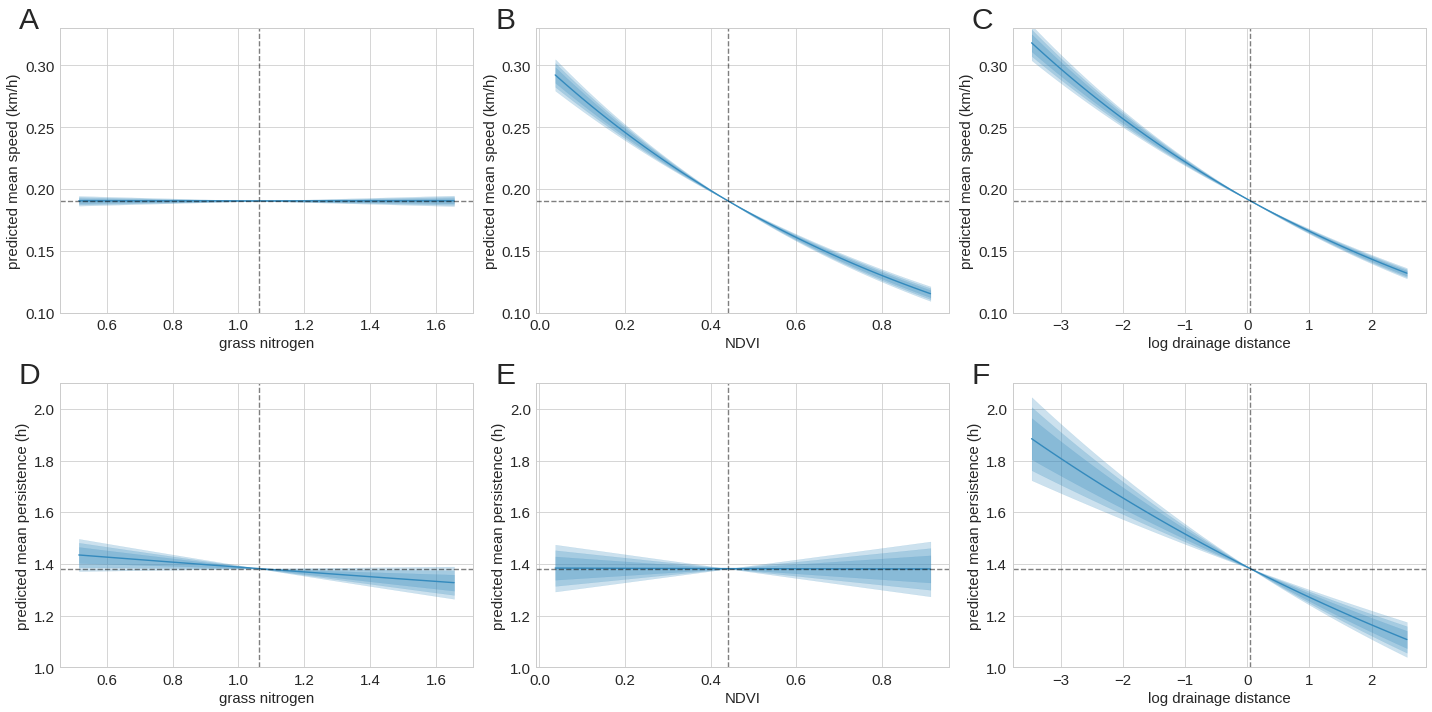

In [122]:
#fig, axs = plt.subplots(2, 3, figsize=(40,20))#,gridspec_kw={'width_ratios': [1,1,1]})
fig, axs = plt.subplots(2, 3, figsize=(20,10))#,gridspec_kw={'width_ratios': [1,1,1.5]})


## first covariate  - Grass Nitrogen
xxx = np.arange(predictor[:,0].min(),predictor[:,0].max(),0.1)
xxx_rescale = ppredictor_means[0] + xxx* ppredictor_std[0]

mu_zero = vgp.mean_amp.numpy()
mu_beta = vgp.beta_amp_mean.numpy()[0]
#sigma_zero=vgp.beta_amp_std.numpy()[0]
sigma_beta=vgp.beta_amp_std.numpy()[0]

regression_mean = mu_zero + mu_beta*xxx
regression_sigma = (sigma_beta**2*xxx**2)**0.5

lnm = mu_zero + mu_beta*xxx 
lnv = (sigma_beta**2*xxx**2)

regression_mean = np.exp(lnm + 0.5*lnv) # mu_zero + mu_beta*xxx 
regression_sigma = ((np.exp(lnv)-1)**0.5)*regression_mean#  (sigma_beta**2*xxx**2)**0.5

ax0 = axs[0, 0].plot(xxx_rescale,regression_mean,color='C1')
axs[0, 0].fill_between(xxx_rescale,regression_mean - 1.28*regression_sigma,regression_mean + 1.28*regression_sigma,color='C1',alpha=0.25)
axs[0, 0].fill_between(xxx_rescale,regression_mean - 1.96*regression_sigma,regression_mean + 1.96*regression_sigma,color='C1',alpha=0.25)
axs[0, 0].fill_between(xxx_rescale,regression_mean - 2.58*regression_sigma,regression_mean + 2.58*regression_sigma,color='C1',alpha=0.25)

axs[0,0].set_xlabel('grass nitrogen',size=15)
axs[0,0].set_ylabel('predicted mean speed (km/h)',size=15)
axs[0,0].text(-0.1,1,'A', size=30, transform=axs[0, 0].transAxes)
axs[0,0].tick_params(axis='both', which='major', labelsize=15)


mu_zero = vgp.mean_len.numpy()
mu_beta = vgp.beta_len_mean.numpy()[0]
sigma_beta=vgp.beta_len_std.numpy()[0]

regression_mean = mu_zero + mu_beta*xxx
regression_sigma = (sigma_beta**2*xxx**2)**0.5


lnm = mu_zero + mu_beta*xxx 
lnv = (sigma_beta**2*xxx**2)

regression_mean = np.exp(lnm + 0.5*lnv) # mu_zero + mu_beta*xxx 
regression_sigma = ((np.exp(lnv)-1)**0.5)*regression_mean#  (sigma_beta**2*xxx**2)**0.5

ax1= axs[1, 0].plot(xxx_rescale,regression_mean,color='C1')
axs[1, 0].fill_between(xxx_rescale,regression_mean - 1.28*regression_sigma,regression_mean + 1.28*regression_sigma,color='C1',alpha=0.25)
axs[1, 0].fill_between(xxx_rescale,regression_mean - 1.96*regression_sigma,regression_mean + 1.96*regression_sigma,color='C1',alpha=0.25)
axs[1, 0].fill_between(xxx_rescale,regression_mean - 2.58*regression_sigma,regression_mean + 2.58*regression_sigma,color='C1',alpha=0.25)

axs[1,0].set_xlabel('grass nitrogen',size=15)
axs[1,0].set_ylabel('predicted mean persistence (h)',size=15)
axs[1,0].text(-0.1,1,'D', size=30, transform=axs[1, 0].transAxes)
axs[1,0].tick_params(axis='both', which='major', labelsize=15)


## second covariate  - NDVI
xxx = np.arange(predictor[:,1].min(),predictor[:,1].max(),0.1)
xxx_rescale = ppredictor_means[1] + xxx* ppredictor_std[1]

mu_zero = vgp.mean_amp.numpy()
mu_beta = vgp.beta_amp_mean.numpy()[1]
sigma_beta=vgp.beta_amp_std.numpy()[1]

regression_mean = mu_zero + mu_beta*xxx
regression_sigma = (sigma_beta**2*xxx**2)**0.5


lnm = mu_zero + mu_beta*xxx 
lnv = (sigma_beta**2*xxx**2)

regression_mean = np.exp(lnm + 0.5*lnv) # mu_zero + mu_beta*xxx 
regression_sigma = ((np.exp(lnv)-1)**0.5)*regression_mean#  (sigma_beta**2*xxx**2)**0.5



ax2= axs[0, 1].plot(xxx_rescale,regression_mean,color='C1')
axs[0, 1].fill_between(xxx_rescale,regression_mean - 1.28*regression_sigma,regression_mean + 1.28*regression_sigma,color='C1',alpha=0.25)
axs[0, 1].fill_between(xxx_rescale,regression_mean - 1.96*regression_sigma,regression_mean + 1.96*regression_sigma,color='C1',alpha=0.25)
axs[0, 1].fill_between(xxx_rescale,regression_mean - 2.58*regression_sigma,regression_mean + 2.58*regression_sigma,color='C1',alpha=0.25)

axs[0,1].set_xlabel('NDVI',size=15)
axs[0,1].set_ylabel('predicted mean speed (km/h)',size=15)
axs[0,1].text(-0.1,1,'B', size=30, transform=axs[0, 1].transAxes)
axs[0,1].tick_params(axis='both', which='major', labelsize=15)


mu_zero = vgp.mean_len.numpy()
mu_beta = vgp.beta_len_mean.numpy()[1]
sigma_beta=vgp.beta_len_std.numpy()[1]

regression_mean = mu_zero + mu_beta*xxx
regression_sigma = (sigma_beta**2*xxx**2)**0.5


lnm = mu_zero + mu_beta*xxx 
lnv = (sigma_beta**2*xxx**2)

regression_mean = np.exp(lnm + 0.5*lnv) # mu_zero + mu_beta*xxx 
regression_sigma = ((np.exp(lnv)-1)**0.5)*regression_mean#  (sigma_beta**2*xxx**2)**0.5



ax3= axs[1, 1].plot(xxx_rescale,regression_mean,color='C1')
axs[1, 1].fill_between(xxx_rescale,regression_mean - 1.28*regression_sigma,regression_mean + 1.28*regression_sigma,color='C1',alpha=0.25)
axs[1, 1].fill_between(xxx_rescale,regression_mean - 1.96*regression_sigma,regression_mean + 1.96*regression_sigma,color='C1',alpha=0.25)
axs[1, 1].fill_between(xxx_rescale,regression_mean - 2.58*regression_sigma,regression_mean + 2.58*regression_sigma,color='C1',alpha=0.25)

axs[1,1].set_xlabel('NDVI',size=15)
axs[1,1].set_ylabel('predicted mean persistence (h)',size=15)
axs[1,1].text(-0.1,1,'E', size=30, transform=axs[1, 1].transAxes)
axs[1,1].tick_params(axis='both', which='major', labelsize=15)



## third covariate  - drainage
xxx = np.arange(predictor[:,2].min(),predictor[:,2].max(),0.1)
xxx_rescale = ppredictor_means[2] + xxx* ppredictor_std[2]

mu_zero = vgp.mean_amp.numpy()
mu_beta = vgp.beta_amp_mean.numpy()[2]
sigma_beta=vgp.beta_amp_std.numpy()[2]

regression_mean = mu_zero + mu_beta*xxx
regression_sigma = (sigma_beta**2*xxx**2)**0.5


lnm = mu_zero + mu_beta*xxx 
lnv = (sigma_beta**2*xxx**2)

regression_mean = np.exp(lnm + 0.5*lnv) # mu_zero + mu_beta*xxx 
regression_sigma = ((np.exp(lnv)-1)**0.5)*regression_mean#  (sigma_beta**2*xxx**2)**0.5



ax2= axs[0, 2].plot(xxx_rescale,regression_mean,color='C1')
axs[0, 2].fill_between(xxx_rescale,regression_mean - 1.28*regression_sigma,regression_mean + 1.28*regression_sigma,color='C1',alpha=0.25)
axs[0, 2].fill_between(xxx_rescale,regression_mean - 1.96*regression_sigma,regression_mean + 1.96*regression_sigma,color='C1',alpha=0.25)
axs[0, 2].fill_between(xxx_rescale,regression_mean - 2.58*regression_sigma,regression_mean + 2.58*regression_sigma,color='C1',alpha=0.25)

axs[0,2].set_xlabel('log drainage distance',size=15)
axs[0,2].set_ylabel('predicted mean speed (km/h)',size=15)
axs[0,2].text(-0.1,1,'C', size=30, transform=axs[0, 2].transAxes)
axs[0,2].tick_params(axis='both', which='major', labelsize=15)


mu_zero = vgp.mean_len.numpy()
mu_beta = vgp.beta_len_mean.numpy()[2]
sigma_beta=vgp.beta_len_std.numpy()[2]

regression_mean = mu_zero + mu_beta*xxx
regression_sigma = (sigma_beta**2*xxx**2)**0.5


lnm = mu_zero + mu_beta*xxx 
lnv = (sigma_beta**2*xxx**2)

regression_mean = np.exp(lnm + 0.5*lnv) # mu_zero + mu_beta*xxx 
regression_sigma = ((np.exp(lnv)-1)**0.5)*regression_mean#  (sigma_beta**2*xxx**2)**0.5



ax3= axs[1, 2].plot(xxx_rescale,regression_mean,color='C1')
axs[1, 2].fill_between(xxx_rescale,regression_mean - 1.28*regression_sigma,regression_mean + 1.28*regression_sigma,color='C1',alpha=0.25)
axs[1, 2].fill_between(xxx_rescale,regression_mean - 1.96*regression_sigma,regression_mean + 1.96*regression_sigma,color='C1',alpha=0.25)
axs[1, 2].fill_between(xxx_rescale,regression_mean - 2.58*regression_sigma,regression_mean + 2.58*regression_sigma,color='C1',alpha=0.25)

axs[1,2].set_xlabel('log drainage distance',size=15)




axs[1,2].set_ylabel('predicted mean persistence (h)',size=15)
axs[1,2].text(-0.1,1,'F', size=30, transform=axs[1, 2].transAxes)
axs[1,2].tick_params(axis='both', which='major', labelsize=15)



loc = ticker.MultipleLocator(base=0.050) # this locator puts ticks at regular intervals
axs[0,0].yaxis.set_major_locator(loc)
axs[0,1].yaxis.set_major_locator(loc)
axs[0,2].yaxis.set_major_locator(loc)


axs[0,0].set_ylim(0.1, 0.33)
axs[0,1].set_ylim(0.1, 0.33)
axs[0,2].set_ylim(0.1, 0.33)

axs[1,0].set_ylim(1.,2.1)
axs[1,1].set_ylim(1.,2.1)
axs[1,2].set_ylim(1.,2.1)


axs[0,0].axvline(x= ppredictor_means[0],linestyle='--', c='k',alpha=0.5)
axs[1,0].axvline(x= ppredictor_means[0],linestyle='--', c='k',alpha=0.5)
axs[0,1].axvline(x= ppredictor_means[1],linestyle='--', c='k',alpha=0.5)
axs[1,1].axvline(x= ppredictor_means[1],linestyle='--', c='k',alpha=0.5)
axs[0,2].axvline(x= ppredictor_means[2],linestyle='--', c='k',alpha=0.5)
axs[1,2].axvline(x= ppredictor_means[2],linestyle='--', c='k',alpha=0.5)


axs[0,0].axhline(y= np.exp(vgp.mean_amp.numpy()),linestyle='--', c='k',alpha=0.5)
axs[0,1].axhline(y= np.exp(vgp.mean_amp.numpy()),linestyle='--', c='k',alpha=0.5)
axs[0,2].axhline(y= np.exp(vgp.mean_amp.numpy()),linestyle='--', c='k',alpha=0.5)

axs[1,0].axhline(y= np.exp(vgp.mean_len.numpy()),linestyle='--', c='k',alpha=0.5)
axs[1,1].axhline(y= np.exp(vgp.mean_len.numpy()),linestyle='--', c='k',alpha=0.5)
axs[1,2].axhline(y= np.exp(vgp.mean_len.numpy()),linestyle='--', c='k',alpha=0.5)
# axs[1,0].axvline(x= ppredictor_means[0],linestyle='--', c='k')
# axs[0,1].axvline(x= ppredictor_means[1],linestyle='--', c='k')
# axs[1,1].axvline(x= ppredictor_means[1],linestyle='--', c='k')
# axs[0,2].axvline(x= ppredictor_means[2],linestyle='--', c='k')
# axs[1,2].axvline(x= ppredictor_means[2],linestyle='--', c='k')




fig.tight_layout()


plt.savefig("serengeti_covariates.png",dpi=300)
plt.show()








In [1178]:
for d in dataset:
    time_points=d[0]
    predictor_values=d[2]
    locations=d[1]
    break
len_vals, amp_vals = vgp.get_samples(locations,predictor_values,S=vgp.num_parallel_samples)   


In [1293]:
K = vgp.non_stat_vel(time_points, len_vals, amp_vals) # BxNxN
K = K + (tf.eye(tf.shape(K)[-1], dtype=tf.float64) * ((tf.nn.softplus(vgp.vgp_observation_noise_variance))+vgp.jitter))
        
L1 = tf.linalg.cholesky(K)

In [1179]:
len_vals.shape

TensorShape([32, 4, 499, 1])

In [1297]:

T,lengthscales, var = time_points, len_vals, amp_vals
"""Non-stationary integrated Matern12 kernel"""
stddev = tf.math.sqrt(var)
#sigma_ = 0.5*(stddev[...,:-1,0,None] + stddev[...,1:,0,None])
#len_ = 0.5*(lengthscales[...,:-1,0,None] + lengthscales[...,1:,0,None])
sigma_ = stddev[...,0,None]# + stddev[...,1:,0,None])
len_ = lengthscales[...,0,None]# + lengthscales[...,1:,0,None])

Ls = tf.square(len_)

L = tf.math.sqrt(0.5*(Ls + tf.linalg.matrix_transpose(Ls)))

prefactL = tf.math.sqrt(tf.matmul(len_, len_, transpose_b=True))
prefactV = tf.matmul(sigma_, sigma_,transpose_b=True)

zeta = tf.math.multiply(prefactV,tf.math.divide(prefactL,L))


tpq1 = tf.math.exp(tf.math.divide(-tf.math.abs(tf.linalg.matrix_transpose(T[:,:-1]) - T[:,1:]),L))
tp1q1 = tf.math.exp(tf.math.divide(-tf.math.abs(tf.linalg.matrix_transpose(T[:,1:]) - T[:,1:]),L))
tpq = tf.math.exp(tf.math.divide(-tf.math.abs(tf.linalg.matrix_transpose(T[:,:-1]) - T[:,:-1]),L))
tp1q = tf.math.exp(tf.math.divide(-tf.math.abs(tf.linalg.matrix_transpose(T[:,1:]) - T[:,:-1]),L))


Epq_grid = tpq1-tp1q1-tpq+tp1q
Epq_grid = (L**2)*Epq_grid

Epq_grid = tf.linalg.set_diag(Epq_grid,(tf.linalg.diag_part(Epq_grid)) + 2.0*len_[...,0]*((T[:,1:,0])-(T[:,:-1,0])))
Epq_grid = zeta*Epq_grid

n = Epq_grid.shape[-1]
LT = tfp.math.fill_triangular(tf.ones(n * (n+1) // 2, dtype=tf.float64))
LTT = tf.linalg.matrix_transpose(LT)

noise = tf.zeros((n,n), dtype=tf.float64)
diag_part = 2.*np.ones(n)
diag_part[0]=1.
off_diag_part = -1.*np.ones(n-1)
noise = tf.linalg.set_diag(noise,diag_part)
noise = tf.linalg.set_diag(noise,off_diag_part,k=1)
noise = tf.linalg.set_diag(noise,off_diag_part,k=-1)

M = Epq_grid +  noise*((tf.nn.softplus(vgp.vgp_observation_noise_variance)))

L2 = tf.linalg.matmul(LT,tf.linalg.cholesky(M))

K3 = tf.linalg.matmul(tf.linalg.matmul(LT, M),LTT)

#K2 = tf.math.cumsum(tf.math.cumsum(Epq_grid,axis=-2,exclusive=False),axis=-1,exclusive=False)
#print()



K2 = K2 + (tf.eye(tf.shape(K2)[-1], dtype=tf.float64) * ((tf.nn.softplus(vgp.vgp_observation_noise_variance))+vgp.jitter))
        
#L2 = tf.linalg.cholesky(K2)
tf.reduce_max(L1-L2)

<tf.Tensor: shape=(), dtype=float64, numpy=8.644925908463108e-08>

In [1289]:

LT = tfp.math.fill_triangular(tf.ones(n * (n+1) // 2, dtype=tf.float64))
LTT = tfp.math.fill_triangular(tf.ones(n * (n+1) // 2, dtype=tf.float64),upper=True)

noise  = tf.linalg.matmul(tf.linalg.inv(LT),tf.linalg.inv(tf.linalg.matrix_transpose(LT)))


noise2  = tf.linalg.inv(tf.linalg.matmul(LTT,LT))#),tf.linalg.inv(LTT))



tf.reduce_sum(AA-noise)
#noise2

<tf.Tensor: shape=(), dtype=float64, numpy=0.0>

In [1269]:
n=10
LT = tfp.math.fill_triangular(tf.ones(n * (n+1) // 2, dtype=tf.float64))
LTT = tfp.math.fill_triangular(tf.ones(n * (n+1) // 2, dtype=tf.float64),upper=True)
print(tf.linalg.inv(tf.linalg.matmul(LTT,LT)).numpy().astype(float))
AA = tf.linalg.matmul(LTT,LT)#.numpy()
AA = np.eye(n)
i=0
for i in range(n-1): AA[i]=AA[i]-AA[i+1]

for i in range(n-1,0,-1): AA[i]=AA[i]-AA[i-1]

AA# - tf.linalg.inv(tf.linalg.matmul(LTT,LT)).numpy()
#tf.linalg.inv(AA)#-tf.linalg.inv(tf.linalg.matmul(LTT,LT))

[[ 1.00000000e+00 -1.00000000e+00 -7.77156117e-16  8.88178420e-16
  -1.05471187e-15  5.55111512e-16  5.55111512e-17 -3.33066907e-16
   1.66533454e-16  0.00000000e+00]
 [-1.00000000e+00  2.00000000e+00 -1.00000000e+00 -1.44328993e-15
   5.55111512e-16  1.11022302e-16  5.55111512e-17 -1.11022302e-16
   5.55111512e-17  0.00000000e+00]
 [ 1.11022302e-16 -1.00000000e+00  2.00000000e+00 -1.00000000e+00
   1.88737914e-15 -1.94289029e-15 -2.22044605e-16  1.19348975e-15
  -5.96744876e-16  0.00000000e+00]
 [-9.99200722e-16  2.10942375e-15 -1.00000000e+00  2.00000000e+00
  -1.00000000e+00  1.77635684e-15  3.88578059e-16 -1.22124533e-15
   6.10622664e-16  0.00000000e+00]
 [ 5.55111512e-17 -1.22124533e-15  2.22044605e-16 -1.00000000e+00
   2.00000000e+00 -1.00000000e+00 -7.77156117e-16  4.44089210e-16
  -2.22044605e-16 -2.46519033e-32]
 [ 4.44089210e-16  1.11022302e-16  1.11022302e-16 -9.99200722e-16
  -1.00000000e+00  2.00000000e+00 -1.00000000e+00 -5.55111512e-17
   8.32667268e-17  0.00000000e+00

array([[ 1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  2., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  2., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  2., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  2., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  2., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  2., -1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  2., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  2., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  2.]])

In [1286]:
n=10
AA = tf.zeros((n,n))
#AA.

diag_part = 2.*np.ones(n)
diag_part[0]=1.

off_diag_part = -1.*np.ones(n-1)
AA = tf.linalg.set_diag(AA,diag_part)
AA = tf.linalg.set_diag(AA,off_diag_part,k=1)
AA = tf.linalg.set_diag(AA,off_diag_part,k=-1)
AA

<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[ 1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  2., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  2., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  2., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  2., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  2., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  2., -1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  2., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  2., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  2.]], dtype=float32)>

In [1229]:
inputmat = tf.ones((10,10))-tf.eye(10)
DD = tf.linalg.band_part(inputmat, 0, -1)

tf.linalg.matmul(DD,DD)

<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[0., 0., 1., 2., 3., 4., 5., 6., 7., 8.],
       [0., 0., 0., 1., 2., 3., 4., 5., 6., 7.],
       [0., 0., 0., 0., 1., 2., 3., 4., 5., 6.],
       [0., 0., 0., 0., 0., 1., 2., 3., 4., 5.],
       [0., 0., 0., 0., 0., 0., 1., 2., 3., 4.],
       [0., 0., 0., 0., 0., 0., 0., 1., 2., 3.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 2.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [ ]:
ppredictor = df[['Nitrogen','NDVI','D_drainage']].values#[...,None]
predictor = (predictor - predictor.mean(axis=0))
predictor = (predictor/predictor.std(axis=0))

In [ ]:

# plt.plot(xxx,(loc+1.96*scale)*xxx)

In [ ]:
# x_grid for plotting

# offset = 0
# gridwidth = 3 # width in kilometres
# xmin = gridwidth*(((x.min()-offset)//gridwidth))
# xmax = gridwidth*(((x.max()+offset)//gridwidth)+2)

# ymin = gridwidth*(((y.min()-offset)//gridwidth))
# ymax = gridwidth*(((y.max()+offset)//gridwidth)+2)

# gridx = np.arange(xmin,xmax,gridwidth)
# gridy = np.arange(ymin,ymax,gridwidth)

# H, yedges, xedges = np.histogram2d(y, x,bins=[gridy,gridx])

# xedges = 0.5*(xedges[1:]+xedges[:-1])
# yedges = 0.5*(yedges[1:]+yedges[:-1])

# xx, yy = np.meshgrid(xedges, yedges, sparse=False)

# # only keep if a wildebeest has been in the cell

# H = maximum_filter(H, size=1)

# xx = xx[H>0]
# yy = yy[H>0]

# x_grid = np.array([xx.flatten(), yy.flatten()])
# X_grid=x_grid.T

# X_grid.shape

Z.shape

In [ ]:
Z.max()

In [ ]:
nsamp = 100

Znew = np.linspace(0.2,0.8,2*num_inducing_points_)[None,...,np.newaxis] 

len_s, amp_s = vgp.get_samples(Znew,S=nsamp)

for i in range(nsamp):
    plt.plot(Znew[0,:,0],len_s[i,0,:,0],alpha=0.1,c='C0')

#plt.ylim(0,0.2)
plt.show()

for i in range(nsamp):
    plt.plot(Znew[0,:,0],amp_s[i,0,:,0],alpha=0.1,c='C0')
    
plt.show()

In [ ]:
mean_list, var_list = vgp.get_marginal(Znew)


len_grid = (vgp.mean_len+mean_list[0]).numpy() + 0.0*var_list[0].numpy()
var_grid = (vgp.mean_amp+mean_list[1]).numpy()

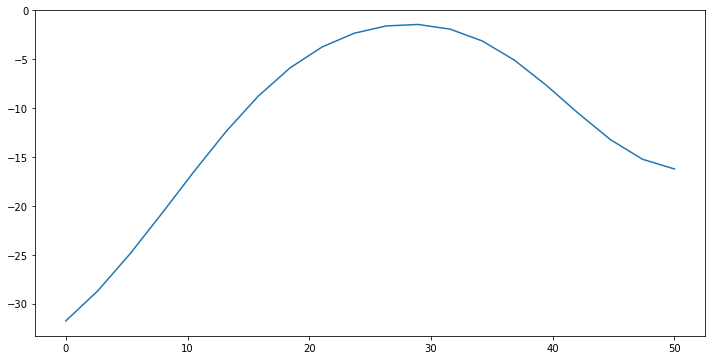

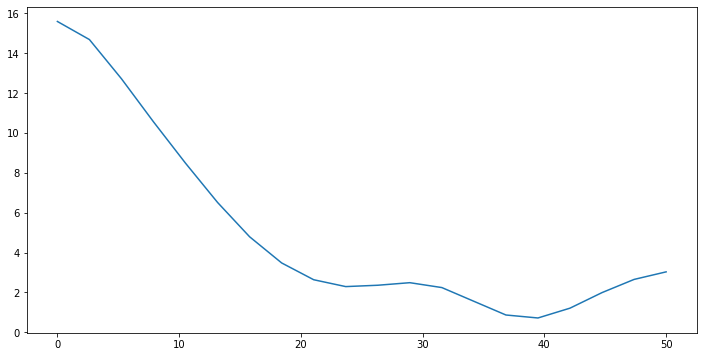

In [186]:
plt.plot(Znew[:,0],len_grid[:,0])
plt.show()
plt.plot(Znew[:,0],var_grid[:,0])
plt.show()

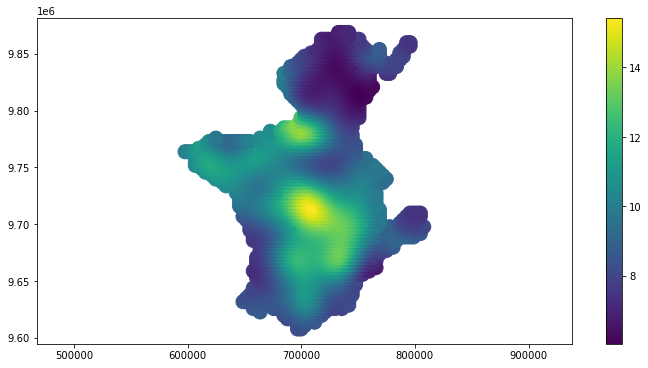

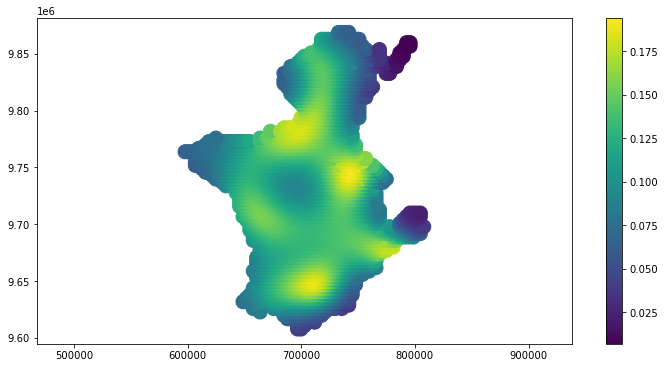

In [16]:
plt.scatter((x_grid[0]+xmean)*1000,(x_grid[1]+ymean)*1000,c=np.exp(var_grid),cmap='viridis',marker='o',s=200)#,vmax=20)#vmin,vmax

#plt.scatter(1000*xmean + 1000*vgp.amp_inducing_index_points.numpy()[:,0],1000*ymean+1000*vgp.amp_inducing_index_points.numpy()[:,1])
plt.axis('equal')
plt.colorbar()
plt.show()

plt.scatter((x_grid[0]+xmean)*1000,(x_grid[1]+ymean)*1000,c=np.exp(len_grid),cmap='viridis',marker='o',s=200)#,vmax=0.16)#vmin,vmax
#plt.scatter(1000*xmean + 1000*vgp.len_inducing_index_points.numpy()[:,0],1000*ymean+1000*vgp.len_inducing_index_points.numpy()[:,1])

plt.axis('equal')
plt.colorbar()
plt.show()

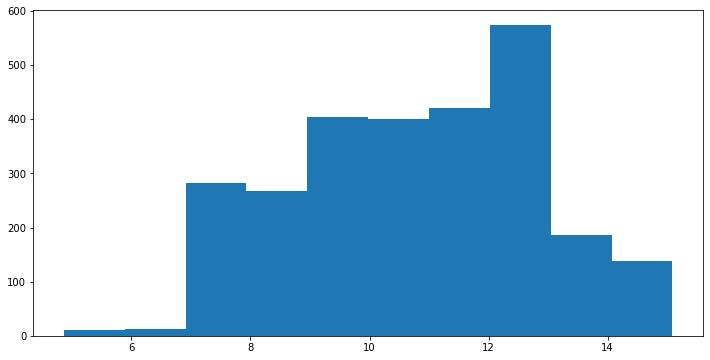

In [47]:
plt.hist(np.exp(var_grid))
plt.show()

In [12]:
vgp.mean_len#.numpy().shape

<tf.Variable 'len_mean:0' shape=(1,) dtype=float64, numpy=array([-2.714713])>

In [163]:
vgp.trainable_variables

(<tf.Variable 'k_amp_a:0' shape=() dtype=float64, numpy=-0.9710715131598405>,
 <tf.Variable 'k_amp_l:0' shape=() dtype=float64, numpy=2.603763203096323>,
 <tf.Variable 'k_len_a:0' shape=() dtype=float64, numpy=0.3732234625181482>,
 <tf.Variable 'k_len_l:0' shape=() dtype=float64, numpy=2.8257930644711804>,
 <tf.Variable 'var_mean:0' shape=(1,) dtype=float64, numpy=array([3.66131576])>,
 <tf.Variable 'len_mean:0' shape=(1,) dtype=float64, numpy=array([-5.2044571])>,
 <tf.Variable 'ind_loc_post:0' shape=(40,) dtype=float64, numpy=
 array([  1.59012218,   1.7032065 ,   2.83345381,   3.18752963,
         -5.54418772,  -5.09641284,   1.44675233,  -6.8486576 ,
          1.38293358,  -7.16233628,  -1.70630133, -12.26570709,
          5.72592126,   2.00460256,  -3.19522468,   2.0049006 ,
         -3.44841935,  -3.91502063,  -1.56840101,  -6.8230548 ,
         -3.11633789,  -3.02200986,  -4.61954021,  -2.21188347,
          6.15267378,   4.99228536,   1.04780517,   6.38835509,
         -2.84728

In [164]:
vgp.amp_inducing_index_points

<tf.Variable 'amp_ind_points:0' shape=(20, 1) dtype=float64, numpy=
array([[40.38402879],
       [57.21070745],
       [10.0960072 ],
       [60.57604318],
       [37.01869305],
       [16.82667866],
       [63.94137891],
       [ 6.73067146],
       [13.46134293],
       [ 3.36533573],
       [33.65335732],
       [ 0.        ],
       [30.28802159],
       [47.11470025],
       [53.84537171],
       [43.74936452],
       [26.92268586],
       [23.55735012],
       [50.48003598],
       [20.19201439]])>

In [ ]:
#fig, axs = plt.subplots(2, 3, figsize=(40,20))#,gridspec_kw={'width_ratios': [1,1,1]})
fig, axs = plt.subplots(2, 3, figsize=(20,10))#,gridspec_kw={'width_ratios': [1,1,1.5]})


## first covariate  - Grass Nitrogen
xxx = np.arange(predictor[:,0].min(),predictor[:,0].max(),0.1)
xxx_rescale = ppredictor_means[0] + xxx* ppredictor_std[0]

mu_zero = vgp.beta_amp_mean.numpy()[0]
mu_beta = vgp.beta_amp_mean.numpy()[1]
sigma_zero=vgp.beta_amp_std.numpy()[0]
sigma_beta=vgp.beta_amp_std.numpy()[1]

regression_mean = mu_zero + mu_beta*xxx
regression_sigma = (sigma_beta**2*xxx**2)**0.5

ax0 = axs[0, 0].plot(xxx_rescale,regression_mean,color='C1')
axs[0, 0].fill_between(xxx_rescale,regression_mean - 1.28*regression_sigma,regression_mean + 1.28*regression_sigma,color='C1',alpha=0.25)
axs[0, 0].fill_between(xxx_rescale,regression_mean - 1.96*regression_sigma,regression_mean + 1.96*regression_sigma,color='C1',alpha=0.25)
axs[0, 0].fill_between(xxx_rescale,regression_mean - 2.58*regression_sigma,regression_mean + 2.58*regression_sigma,color='C1',alpha=0.25)

axs[0,0].set_xlabel('grass nitrogen',size=15)
axs[0,0].set_ylabel('predicted log mean speed',size=15)
axs[0,0].text(-0.15,1,'A', size=30, transform=axs[0, 0].transAxes)
axs[0,0].tick_params(axis='both', which='major', labelsize=15)


mu_zero = vgp.beta_len_mean.numpy()[0]
mu_beta = vgp.beta_len_mean.numpy()[1]
sigma_zero=vgp.beta_len_std.numpy()[0]
sigma_beta=vgp.beta_len_std.numpy()[1]

regression_mean = mu_zero + mu_beta*xxx
regression_sigma = (sigma_zero**2 + sigma_beta**2*xxx**2)**0.5

ax1= axs[1, 0].plot(xxx_rescale,regression_mean,color='C1')
axs[1, 0].fill_between(xxx_rescale,regression_mean - 1.28*regression_sigma,regression_mean + 1.28*regression_sigma,color='C1',alpha=0.25)
axs[1, 0].fill_between(xxx_rescale,regression_mean - 1.96*regression_sigma,regression_mean + 1.96*regression_sigma,color='C1',alpha=0.25)
axs[1, 0].fill_between(xxx_rescale,regression_mean - 2.58*regression_sigma,regression_mean + 2.58*regression_sigma,color='C1',alpha=0.25)

axs[1,0].set_xlabel('grass nitrogen',size=15)
axs[1,0].set_ylabel('predicted log mean persistence',size=15)
axs[1,0].text(-0.2,1,'D', size=30, transform=axs[1, 0].transAxes)
axs[1,0].tick_params(axis='both', which='major', labelsize=15)


## second covariate  - NDVI
xxx = np.arange(predictor[:,2].min(),predictor[:,2].max(),0.1)
xxx_rescale = ppredictor_means[1] + xxx* ppredictor_std[1]

mu_zero = vgp.beta_amp_mean.numpy()[0]
mu_beta = vgp.beta_amp_mean.numpy()[2]
sigma_zero=vgp.beta_amp_std.numpy()[0]
sigma_beta=vgp.beta_amp_std.numpy()[2]

regression_mean = mu_zero + mu_beta*xxx
regression_sigma = (sigma_zero**2 + sigma_beta**2*xxx**2)**0.5

ax2= axs[0, 1].plot(xxx_rescale,regression_mean,color='C1')
axs[0, 1].fill_between(xxx_rescale,regression_mean - 1.28*regression_sigma,regression_mean + 1.28*regression_sigma,color='C1',alpha=0.25)
axs[0, 1].fill_between(xxx_rescale,regression_mean - 1.96*regression_sigma,regression_mean + 1.96*regression_sigma,color='C1',alpha=0.25)
axs[0, 1].fill_between(xxx_rescale,regression_mean - 2.58*regression_sigma,regression_mean + 2.58*regression_sigma,color='C1',alpha=0.25)

axs[0,1].set_xlabel('NDVI',size=15)
axs[0,1].set_ylabel('predicted log mean speed',size=15)
axs[0,1].text(-0.15,1,'B', size=30, transform=axs[0, 1].transAxes)
axs[0,1].tick_params(axis='both', which='major', labelsize=15)


mu_zero = vgp.beta_len_mean.numpy()[0]
mu_beta = vgp.beta_len_mean.numpy()[2]
sigma_zero=vgp.beta_len_std.numpy()[0]
sigma_beta=vgp.beta_len_std.numpy()[2]

regression_mean = mu_zero + mu_beta*xxx
regression_sigma = (sigma_zero**2 + sigma_beta**2*xxx**2)**0.5

ax3= axs[1, 1].plot(xxx_rescale,regression_mean,color='C1')
axs[1, 1].fill_between(xxx_rescale,regression_mean - 1.28*regression_sigma,regression_mean + 1.28*regression_sigma,color='C1',alpha=0.25)
axs[1, 1].fill_between(xxx_rescale,regression_mean - 1.96*regression_sigma,regression_mean + 1.96*regression_sigma,color='C1',alpha=0.25)
axs[1, 1].fill_between(xxx_rescale,regression_mean - 2.58*regression_sigma,regression_mean + 2.58*regression_sigma,color='C1',alpha=0.25)

axs[1,1].set_xlabel('NDVI',size=15)
axs[1,1].set_ylabel('predicted log mean persistence',size=15)
axs[1,1].text(-0.15,1,'E', size=30, transform=axs[1, 1].transAxes)
axs[1,1].tick_params(axis='both', which='major', labelsize=15)



## third covariate  - drainage
xxx = np.arange(predictor[:,3].min(),predictor[:,3].max(),0.1)
xxx_rescale = ppredictor_means[2] + xxx* ppredictor_std[2]

mu_zero = vgp.beta_amp_mean.numpy()[0]
mu_beta = vgp.beta_amp_mean.numpy()[3]
sigma_zero=vgp.beta_amp_std.numpy()[0]
sigma_beta=vgp.beta_amp_std.numpy()[3]

regression_mean = mu_zero + mu_beta*xxx
regression_sigma = (sigma_zero**2 + sigma_beta**2*xxx**2)**0.5

ax2= axs[0, 2].plot(xxx_rescale,regression_mean,color='C1')
axs[0, 2].fill_between(xxx_rescale,regression_mean - 1.28*regression_sigma,regression_mean + 1.28*regression_sigma,color='C1',alpha=0.25)
axs[0, 2].fill_between(xxx_rescale,regression_mean - 1.96*regression_sigma,regression_mean + 1.96*regression_sigma,color='C1',alpha=0.25)
axs[0, 2].fill_between(xxx_rescale,regression_mean - 2.58*regression_sigma,regression_mean + 2.58*regression_sigma,color='C1',alpha=0.25)

axs[0,2].set_xlabel('drainage distance',size=15)
axs[0,2].set_ylabel('predicted log mean speed',size=15)
axs[0,2].text(-0.15,1,'C', size=30, transform=axs[0, 2].transAxes)
axs[0,2].tick_params(axis='both', which='major', labelsize=15)


mu_zero = vgp.beta_len_mean.numpy()[0]
mu_beta = vgp.beta_len_mean.numpy()[3]
sigma_zero=vgp.beta_len_std.numpy()[0]
sigma_beta=vgp.beta_len_std.numpy()[3]

regression_mean = mu_zero + mu_beta*xxx
regression_sigma = (sigma_zero**2 + sigma_beta**2*xxx**2)**0.5

ax3= axs[1, 2].plot(xxx_rescale,regression_mean,color='C1')
axs[1, 2].fill_between(xxx_rescale,regression_mean - 1.28*regression_sigma,regression_mean + 1.28*regression_sigma,color='C1',alpha=0.25)
axs[1, 2].fill_between(xxx_rescale,regression_mean - 1.96*regression_sigma,regression_mean + 1.96*regression_sigma,color='C1',alpha=0.25)
axs[1, 2].fill_between(xxx_rescale,regression_mean - 2.58*regression_sigma,regression_mean + 2.58*regression_sigma,color='C1',alpha=0.25)

axs[1,2].set_xlabel('drainage distance',size=15)



axs[1,2].set_ylabel('predicted log mean persistence',size=15)
axs[1,2].text(-0.15,1,'F', size=30, transform=axs[1, 2].transAxes)
axs[1,2].tick_params(axis='both', which='major', labelsize=15)


# axs[0,0].set_ylim(-2.6,-1.20)
# axs[0,1].set_ylim(-2.6,-1.20)
# axs[0,2].set_ylim(-2.6,-1.20)

# axs[1,0].set_ylim(0.65,1.2)
# axs[1,1].set_ylim(0.65,1.2)
# axs[1,2].set_ylim(0.65,1.2)

fig.tight_layout()


plt.savefig("serengeti_covariates.png",dpi=300)
plt.show()








In [19]:

# with open('../data/mcmc/serengeti_data_param_dict.pkl', 'rb') as f:
#     loadp = pickle.load(f)
# m.noise_variance.assign(loadp['noise_variance'])
# m.V_len.assign(loadp['V_len'])
# m.V_len_mean.assign(loadp['V_len_mean'])
# m.k_len_a.assign(loadp['k_len_a'])
# m.k_len_l.assign(loadp['k_len_l'])
# m.V_var.assign(loadp['V_var'])
# m.V_var_mean.assign(loadp['V_var_mean'])
# m.k_var_a.assign(loadp['k_var_a'])
# m.k_var_l.assign(loadp['k_var_l'])

In [20]:
# tf.nn.softplus(0.1)
# #np.log(np.exp()-1)

# x = np.log(1+np.exp(0.1))
# print(x)
# np.log(np.exp(x)-1)
m.V_len.shape

TensorShape([1048])

In [21]:
m.dist_optimize(iters=100)


Loss 283608.597512: 100%|██████████| 100/100 [16:09<00:00,  9.70s/it]


[41.00022718]
[19.19308402]
[-0.63057695]
[0.25299545]
[67.48771943]
[-2.661876]


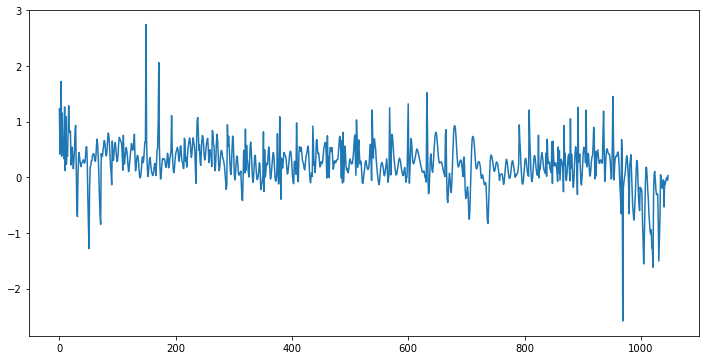

In [22]:
# x_grid
print(np.exp((m.k_len_l).numpy()))
print(np.exp((m.k_var_l).numpy()))

print((m.k_len_a).numpy())
print((m.k_var_a).numpy())
#print(m.gp_prior(m.len_transform(m.V_len),m.var_transform(m.V_var)))
print(1000*tf.math.softplus(m.noise_variance).numpy())

print(m.noise_variance.numpy())
plt.plot(m.V_var.numpy())

[3.72383265]
[3.08062998]
[-0.2680196]
[0.56919463]
[65.25503724]
[-2.6966471]


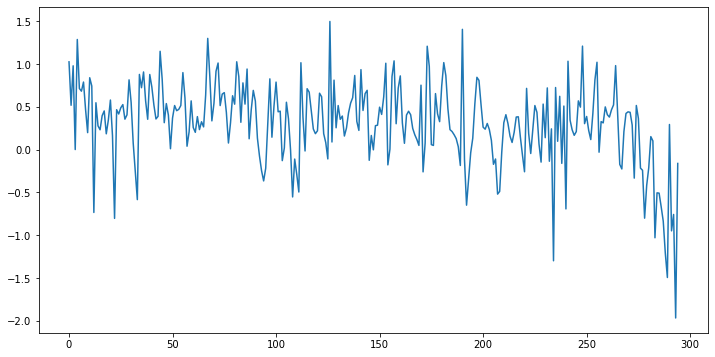

In [10]:

# x_grid
print((m.k_len_l).numpy())
print((m.k_var_l).numpy())

print((m.k_len_a).numpy())
print((m.k_var_a).numpy())

print(1000*tf.math.softplus(m.noise_variance).numpy())

print(m.noise_variance.numpy())
plt.plot(m.V_var.numpy())

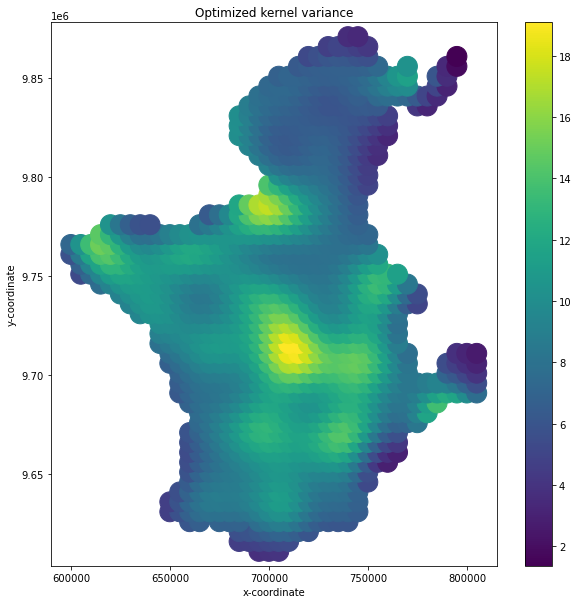

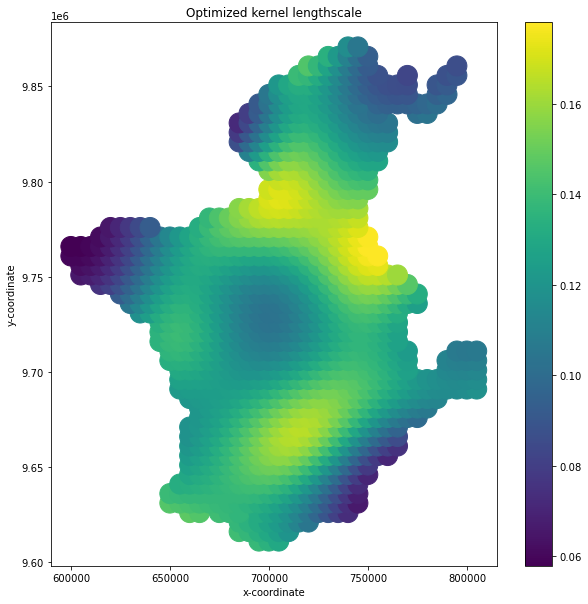

In [24]:
offset = 0
gridwidth = 5 # width in kilometres
xmin = gridwidth*(((x.min()-offset)//gridwidth))
xmax = gridwidth*(((x.max()+offset)//gridwidth)+2)

ymin = gridwidth*(((y.min()-offset)//gridwidth))
ymax = gridwidth*(((y.max()+offset)//gridwidth)+2)

gridx = np.arange(xmin,xmax,gridwidth)
gridy = np.arange(ymin,ymax,gridwidth)

H, yedges, xedges = np.histogram2d(y, x,bins=[gridy,gridx])

xedges = 0.5*(xedges[1:]+xedges[:-1])
yedges = 0.5*(yedges[1:]+yedges[:-1])

xx, yy = np.meshgrid(xedges, yedges, sparse=False)

# only keep if a wildebeest has been in the cell


H = maximum_filter(H, size=1)

#A[A !=0] = 1
#A[A ==0] = 0

xx = xx[H>0]
yy = yy[H>0]


# xx = xx[np.abs(yy)<50]
# yy = yy[np.abs(yy)<50]

x_grid = np.array([xx.flatten(), yy.flatten()])
x_grid=x_grid.T

x_grid.shape

len_grid = m.predict_length(Xnew=x_grid).numpy()#.reshape(numy,numx)
var_grid = m.predict_var(Xnew=x_grid).numpy()#.reshape(numy,numx)



plt.figure(figsize=(10,10))
ax = plt.subplot()
# dfpark[dfpark.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=ax,color='black',linewidth=1)#, edgecolor='black')


# ax.set_aspect('equal')
# xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
# ax.annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
#             arrowprops=dict(facecolor='black', width=5, headwidth=15),
#             ha='center', va='center', fontsize=20,
#             xycoords=ax.transAxes)


plt.scatter((x_grid[:,0]+xmean)*1000,(x_grid[:,1]+ymean)*1000,c=var_grid[:,0]**0.5,cmap='viridis',marker='o',s=400)#,vmax=10)
#plt.show()
#plt.scatter(x_grid[0],x_grid[1],c=len_grid,cmap='viridis',marker='o',s=200)#,vmax=0.50)

plt.colorbar()
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.title('Optimized kernel variance')
plt.axis('equal')
plt.show()

plt.figure(figsize=(10,10))
# ax = plt.subplot()
# dfpark[dfpark.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=ax,color='black',linewidth=1)#, edgecolor='black')


# ax.set_aspect('equal')
# xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
# ax.annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
#             arrowprops=dict(facecolor='black', width=5, headwidth=15),
#             ha='center', va='center', fontsize=20,
#             xycoords=ax.transAxes)


plt.scatter((x_grid[:,0]+xmean)*1000,(x_grid[:,1]+ymean)*1000,c=len_grid,cmap='viridis',marker='o',s=400)#,vmax=0.200)
#plt.show()
#plt.scatter(x_grid[0],x_grid[1],c=len_grid,cmap='viridis',marker='o',s=200)#,vmax=0.50)

plt.colorbar()
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.title('Optimized kernel lengthscale')

plt.show()

0.011148105992106971


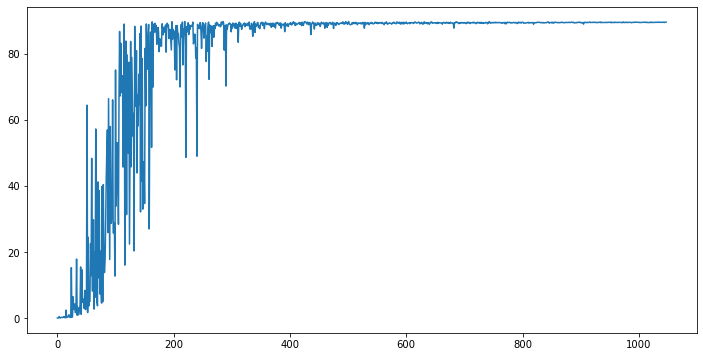

In [41]:
# initial guess at step size based on effect on GP functions
offset = m.X_grid.shape[0]/X.shape[0] # estimate of relative difference between gp prior and data likelihood

print(offset)
with tf.GradientTape() as t:
    kernel_l = m.kern_len(tf.math.exp(m.k_len_a), tf.math.exp(m.k_len_l))
    K_len = kernel_l.matrix(m.X_grid,m.X_grid)
    L_len = tf.linalg.cholesky(K_len + tf.eye(tf.shape(m.X_grid)[0], dtype=tf.float64) * 1e-6)
    F_len_v = tf.squeeze(tf.linalg.matmul(L_len, tf.expand_dims(m.V_len,-1)))
    f_norm = tf.norm(F_len_v)
grad_len = t.gradient(f_norm,[m.V_len])[0].numpy()
len_step = (offset+np.abs(grad_len))**-1

with tf.GradientTape() as t:
    kernel_v = m.kern_var(tf.math.exp(m.k_var_a), tf.math.exp(m.k_var_l))
    K_var = kernel_v.matrix(m.X_grid,m.X_grid)
    L_var = tf.linalg.cholesky(K_var + tf.eye(tf.shape(m.X_grid)[0], dtype=tf.float64) * 1e-6)
    F_var_v = tf.squeeze(tf.linalg.matmul(L_var, tf.expand_dims(m.V_var,-1)))
    f_norm = tf.norm(F_var_v)
grad_var = t.gradient(f_norm,[m.V_var])[0].numpy()
var_step = (offset+np.abs(grad_var))**-1


plt.plot(var_step)
plt.show()

In [4]:
print(tfp.__version__)
print(tf.__version__)

0.13.0-rc0
2.5.0


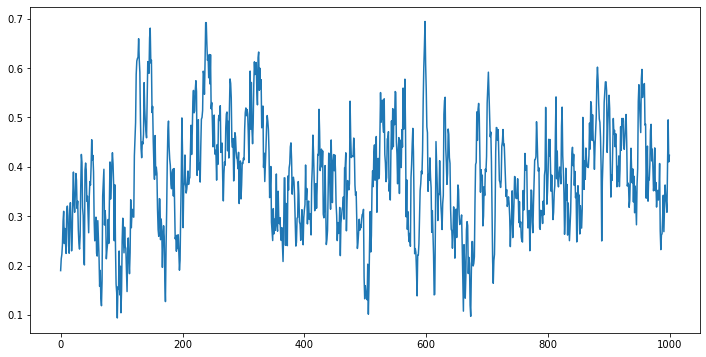

279

In [5]:

aa = np.load('../data/mcmc/serengeti_data_1_0.npy')
aa.shape

plt.plot(aa[:,278])
plt.show()

esses = tfp.mcmc.effective_sample_size(aa[::10]).numpy().reshape((-1))
esses.argmin()

In [6]:

df = pd.read_csv('../data/wildebeest_data/wildebeest2019.csv')
# Select all the rows where the OWNER is HOPCRAFT
df = df[df['OWNER'] == 'HOPCRAFT']
#Select all the rows where the species is WB
df = df[df['SPECIES'] == 'WB']
#Select all the rows where the animal is a migrant
df = df[df['migrant'] == 1]
# only use values post 2013 (higher accuracy, more fixes, accurate resident indicator)
df = df[pd.to_datetime(df['Date']).dt.year>=2013]


print(len(df))
#df = df[df.steptime<12]
print(len(df))

df['ID'] = df['AID'].astype('category').cat.rename_categories(range(0, df['AID'].nunique())).astype('int')




/maths/ctorney/anaconda3/envs/tf_pre/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (0,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


94007
94007


In [7]:



#Load the data

df = pd.read_csv('../data/wildebeest_data/wildebeest2019.csv')
# Select all the rows where the OWNER is HOPCRAFT
df = df[df['OWNER'] == 'HOPCRAFT']
#Select all the rows where the species is WB
df = df[df['SPECIES'] == 'WB']
#Select all the rows where the animal is a migrant
df = df[df['migrant'] == 1]
# only use values post 2013 (higher accuracy, more fixes, accurate resident indicator)
df = df[pd.to_datetime(df['Date']).dt.year>=2013]


#df = df[df.steptime<12]

df['ID'] = df['AID'].astype('category').cat.rename_categories(range(0, df['AID'].nunique())).astype('int')

secs =(pd.to_datetime(df['Date'])- pd.datetime(2013,1,1)).dt.seconds.astype(float).values
days = (pd.to_datetime(df['Date'])- pd.datetime(2013,1,1)).dt.days.astype(float).values

T = (days*24*60+secs/60)/(60*24)
T = T[:,None]
x = df.x.values/1000
y = df.y.values/1000
xmean =  x.mean()
ymean = y.mean()
x = x - xmean
y = y - ymean

ID = df['ID'].values 

X = np.zeros((len(x),2))
X[:,0] = x
X[:,1] = y

print(np.shape(X))
print(np.shape(T))

/maths/ctorney/anaconda3/envs/tf_pre/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (0,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(94007, 2)
(94007, 1)


<ipython-input-7-f4fbfcdedfe6>:18: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  secs =(pd.to_datetime(df['Date'])- pd.datetime(2013,1,1)).dt.seconds.astype(float).values
<ipython-input-7-f4fbfcdedfe6>:19: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  days = (pd.to_datetime(df['Date'])- pd.datetime(2013,1,1)).dt.days.astype(float).values


In [8]:
# Set up the grid
offset = 0
gridwidth = 10 # width in kilometres
xmin = gridwidth*(((x.min()-offset)//gridwidth))
xmax = gridwidth*(((x.max()+offset)//gridwidth)+2)

ymin = gridwidth*(((y.min()-offset)//gridwidth))
ymax = gridwidth*(((y.max()+offset)//gridwidth)+2)

gridx = np.arange(xmin,xmax,gridwidth)
gridy = np.arange(ymin,ymax,gridwidth)

H, yedges, xedges = np.histogram2d(y, x,bins=[gridy,gridx])

xedges = 0.5*(xedges[1:]+xedges[:-1])
yedges = 0.5*(yedges[1:]+yedges[:-1])

xx, yy = np.meshgrid(xedges, yedges, sparse=False)

# only keep if a wildebeest has been in the cell or a neighbouring cell
H = maximum_filter(H, size=1)


xx = xx[H>0]
yy = yy[H>0]


x_grid = np.array([xx.flatten(), yy.flatten()])
x_grid = x_grid.T

x_grid_r = x_grid.copy()
np.random.shuffle(x_grid_r)
print(x_grid_r.shape)

m = GPMove(T,x_grid_r,X,ID,BATCH_SIZE=1000,k_len_l=10.0, k_var_l=10.0)

(295, 2)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [9]:
m.dist_optimize(iters=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Instructions for updating:
`jitter` is deprecated; please use `marginal_fn` directly.


Loss 254834.322910: 100%|██████████| 1000/1000 [33:08<00:00,  1.99s/it]


0.0031380641867095


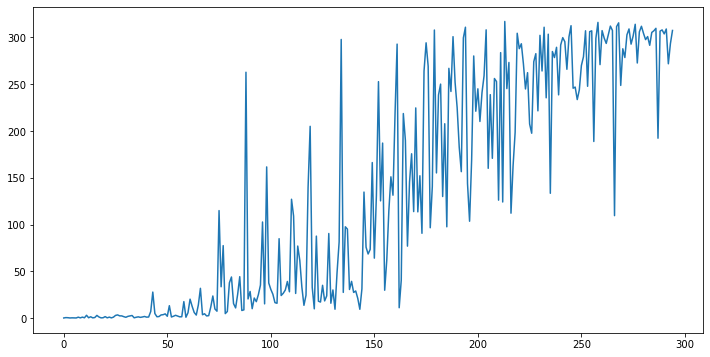

In [18]:


num_warmup = 3
warmup_steps = 10#200
n_samples = 10#500
num_leapfrog_steps=10
step_size=[np.float64(0.1)*len_step,np.float64(0.1)*var_step]

n_chains=10
init_value = [tf.tile(tf.expand_dims((m.V_len),0),[n_chains,1]),tf.tile(tf.expand_dims((m.V_var),0),[n_chains,1])]
                                           


In [19]:

kernel = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=m.model_log_prob,step_size=step_size, num_leapfrog_steps=num_leapfrog_steps)


kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(inner_kernel=kernel, num_adaptation_steps=warmup_steps)

pbar = tfp.experimental.mcmc.ProgressBarReducer(warmup_steps + n_samples - 1)
kernel = tfp.experimental.mcmc.WithReductions(kernel, pbar)

samples= tfp.mcmc.sample_chain(num_results=n_samples, num_burnin_steps=warmup_steps,
                                current_state=init_value, kernel=kernel, trace_fn=None)

100%|██████████| 19/19 [40:29<00:00, 127.87s/it] 


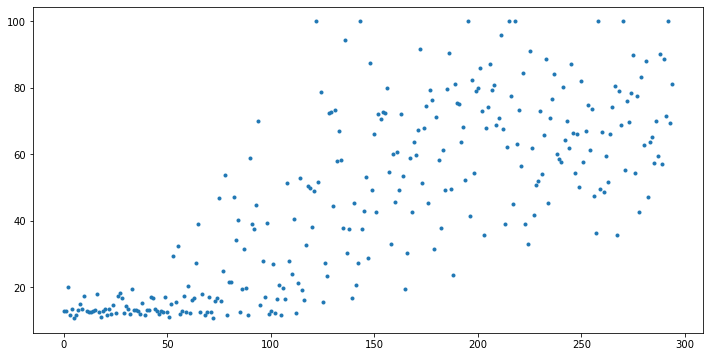

In [20]:
esses2 = [tfp.mcmc.effective_sample_size(ss,cross_chain_dims=1).numpy().reshape((-1)) for ss in samples]
plt.plot(esses2[0],'.')
#plt.plot(esses[0],'.')

plt.show()
#plt.plot(esses[0],esses2[0],'.')
#plt.show()

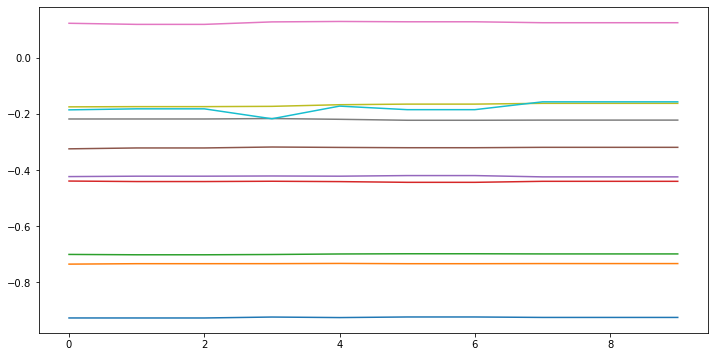

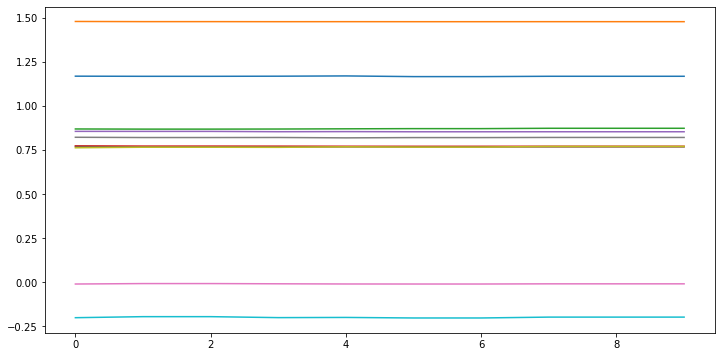

In [23]:
j=2

for ss in samples:
    plt.plot(ss[:,j,:10])
    plt.show()

In [6]:
# for aa in pd.unique(df.AID):
#     xcheck = df[df.AID==aa].x.values/1000
#     ycheck = df[df.AID==aa].y.values/1000
#     print(aa,xcheck.shape[0])

In [7]:
# # plt.hist(df.dist,bins=100)
# # plt.show()
# # df.dist.argmax()
# # df.iloc[15579]
# check = 'W51'
# xcheck = df[df.AID==check].x.values/1000
# ycheck = df[df.AID==check].y.values/1000
# tcheck = pd.to_datetime(df[df.AID==check].Date)
# xcheck =xcheck - xmean
# ycheck = ycheck - ymean

# plt.plot(tcheck,xcheck,'o')
# plt.plot(tcheck,ycheck,'o')
# #plt.axis('equal')
# plt.show()

In [8]:
secs =(pd.to_datetime(df['Date'])- pd.datetime(2013,1,1)).dt.seconds.astype(float).values
days = (pd.to_datetime(df['Date'])- pd.datetime(2013,1,1)).dt.days.astype(float).values

T = (days*24*60+secs/60)/(60*24)
T = T[:,None]
x = df.x.values/1000
y = df.y.values/1000
xmean =  x.mean()
ymean = y.mean()
x = x - xmean
y = y - ymean

ID = df['ID'].values 

X = np.zeros((len(x),2))
X[:,0] = x
X[:,1] = y

<ipython-input-8-a9fe4b12ceb9>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  secs =(pd.to_datetime(df['Date'])- pd.datetime(2013,1,1)).dt.seconds.astype(float).values
<ipython-input-8-a9fe4b12ceb9>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  days = (pd.to_datetime(df['Date'])- pd.datetime(2013,1,1)).dt.days.astype(float).values


In [9]:
# plt.hist(df.steptime,range=(0,10),bins=100)
# plt.show()

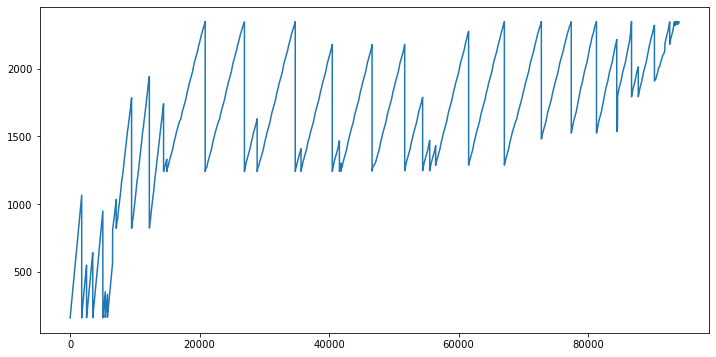

In [10]:
plt.plot(T)

In [13]:

offset = 10
gridwidth = 10 # width in kilometres
xmin = gridwidth*(((x.min()-offset)//gridwidth))
xmax = gridwidth*(((x.max()+offset)//gridwidth)+2)

ymin = gridwidth*(((y.min()-offset)//gridwidth))
ymax = gridwidth*(((y.max()+offset)//gridwidth)+2)

gridx = np.arange(xmin,xmax,gridwidth)
gridy = np.arange(ymin,ymax,gridwidth)

H, yedges, xedges = np.histogram2d(y, x,bins=[gridy,gridx])

xedges = 0.5*(xedges[1:]+xedges[:-1])
yedges = 0.5*(yedges[1:]+yedges[:-1])

xx, yy = np.meshgrid(xedges, yedges, sparse=False)

# only keep if a wildebeest has been in the cell or a neighbouring cell
H = maximum_filter(H, size=1)


xx = xx[H>0]
yy = yy[H>0]


x_grid = np.array([xx.flatten(), yy.flatten()])
X_grid=x_grid.T

x_grid.shape


(2, 295)

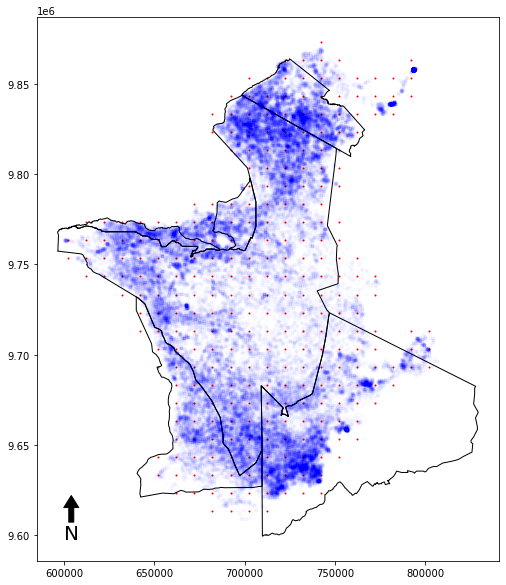

In [69]:
# # Set up the grid
# num=int(20)


# x1=y1 = np.array(np.linspace(-10,-5,int(num/2)))
# x2=y2 = np.array(np.linspace(5,10,int(num/2)))

# x = y = np.array(np.linspace(-5, 5, num))

# x = np.concatenate([x1,x])
# x = np.concatenate([x,x2])

# y = np.concatenate([y1,y])
# y = np.concatenate([y,y2])[...,np.newaxis]


# Unew = np.zeros((2*num,2))
# Unew[:,0] = np.squeeze(x)
# Unew[:,1] = np.squeeze(y)
# xx, yy = np.meshgrid(x, y, sparse=False)
# x_grid = np.array([xx.flatten(), yy.flatten()])
# X_grid=x_grid.T
# print(np.shape(X_grid))

In [70]:
# df = pd.read_csv('Real_data.csv')
# T = (df['Time'].values[:,None])
# ID = df['ID'].values

# X_x = df['Latitude'].values
# X_y = df['Longitude'].values
# X = np.zeros((len(X_x),2))
# X[:,0] = X_x
# X[:,1] = X_y


In [71]:
# #standardize T 
# T = (T-np.mean(T))/np.std(T)

In [72]:
print(np.shape(X))
print(np.shape(T))
n = np.shape(X)[0]
#all the sizes match

(94007, 2)
(94007, 1)


In [73]:
m = GPMove(T,X_grid,X,ID,BATCH_SIZE=1000,min_kl=np.float64(gridwidth), init_k_len_l=10.0, init_k_var_l=10.0)

In [74]:
# # m.K

# initial_chain_states= m.trainable_parameters

In [75]:


# # Initialize the HMC transition kernel.
# num_results = int(5)
# t0 = time.time()
# samples, kernel_results = tfp.mcmc.sample_chain(
#     num_results=num_results,
#     num_burnin_steps=5,
#     current_state=initial_chain_states,
#     kernel= tfp.mcmc.HamiltonianMonteCarlo(
#             target_log_prob_fn=m.likelihood_fn,
#             step_size=[np.float64(1e-1)],
#             num_leapfrog_steps=8),trace_fn=lambda current_state,kernel_results: kernel_results)
# t1 = time.time()
# print("Inference ran in {:.2f}s.".format(t1-t0))



In [76]:
print(np.shape(m.T))
print(np.shape(m.X))
#138,500 obs in total, 277 batches each having 500 points

(75, 1000, 1)
(75, 1000, 2)


In [77]:
# for i in range(277):
#     thisX = m.X[i]
    
#     thisX = thisX[1:]-thisX[0]
#     thisX = thisX.numpy()
#     thisT = m.T[i]
#     thisT = thisT[1:]-thisT[0]
#     thisT = thisT.numpy()
#     thisX = np.diff(thisX,axis=0)/np.diff(thisT,axis=0)
#     #print(thisT.max())
#     plt.plot(thisT[1:],thisX[:,0])
# plt.show()
    

In [78]:
learning_rate = tf.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-1,
    decay_steps=50,
    decay_rate=0.99,
    staircase=True)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.1,beta_2=0.99)
train_steps = 1000
pbar = tqdm(range(train_steps))
loss_history = np.zeros((train_steps))

for i in pbar:
    with tf.GradientTape() as t:
        loss = -m.likelihood_fn(*m.trainable_parameters)
    loss_history[i] = loss.numpy()
    
    #lenll = (m.min_kl+tf.nn.softplus(m.k_len).numpy())

    pbar.set_description("Loss %f" % loss_history[i])

    gradients = t.gradient(loss, m.trainable_parameters)
    optimizer.apply_gradients(zip(gradients, m.trainable_parameters))

Loss 254244.916779: 100%|██████████| 1000/1000 [21:41<00:00,  1.30s/it]


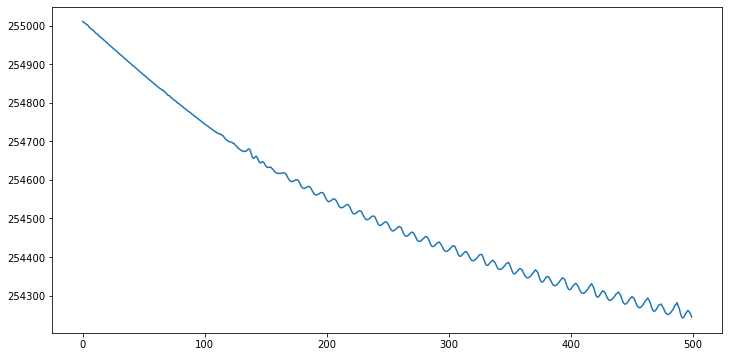

In [79]:
plt.plot(loss_history[500:])
plt.show()

[34.32089304]
[32.76339362]
[1.77829641]
[13.24999068]
[79.75678174]
[-2.48863008]


In [81]:


# xx = np.arange(-150,150,gridwidth)
# yy = np.arange(-150,150,gridwidth)

# numx = xx.shape[0]
# numy = yy.shape[0]
# xx, yy = np.meshgrid(xx, yy, sparse=False)
# x_grid = np.array([xx.flatten(), yy.flatten()],dtype=np.float64)
# x_grid=x_grid.T

(2, 17748)

In [12]:
var_grid.shape
x_grid.shape

(295, 2)

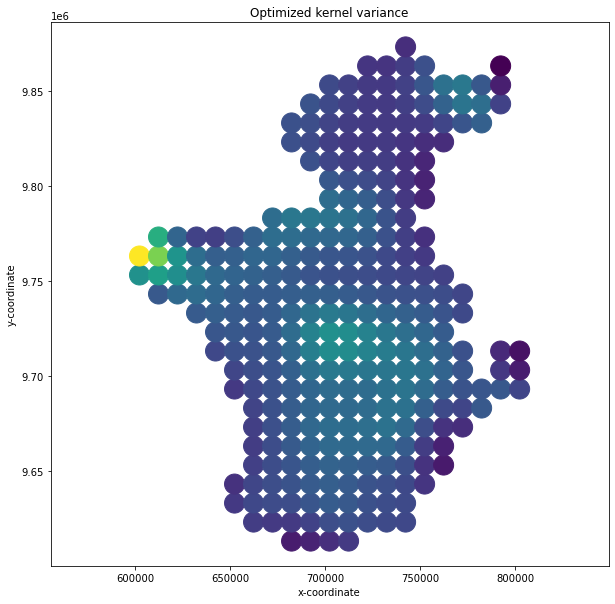

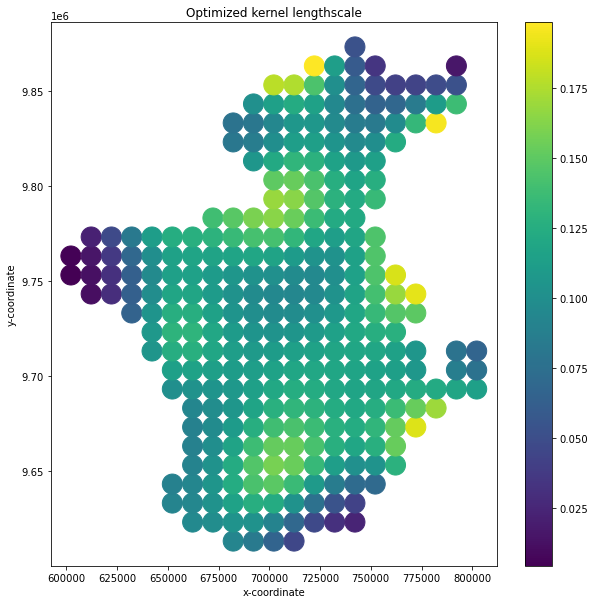

In [30]:
# #plt.contourf(xx,yy,len_grid,levels=200,vmax=1)
# plt.scatter(x_grid[0],x_grid[1],c=len_grid,cmap='viridis',marker='o',s=200)#,vmax=0.50)

# #plt.plot(X[:,0],X[:,1],'.',markersize=1)
# #
# print(xmean)
# ser_x = (702195.29/1000-xmean)
# ser_y = (9729317.33/1000-ymean)

# gate_x = (722118.74/1000-xmean)

# gate_y = (9686765.47/1000-ymean)


# rob_x = (686920.56/1000-xmean)

# rob_y = (9761581.10/1000-ymean)

# #687519.40, 9827726.60
# 709597.35
# 9827454.87
# mara_x = (709597.40/1000-xmean)

# mara_y = (9827454.60/1000-ymean)
# plt.plot(ser_x,ser_y,'*',c='r',markersize=10,alpha=0.5)
# plt.plot(gate_x,gate_y,'*',c='r',markersize=10,alpha=0.5)
# plt.plot(rob_x,rob_y,'*',c='r',markersize=10,alpha=0.5)
# plt.plot(mara_x,mara_y,'*',c='r',markersize=10,alpha=0.5)
# plt.colorbar()

# plt.axis('equal')

# plt.xlabel('x-coordinate')
# plt.ylabel('y-coordinate')
# plt.title('Optimized kernel lengthscale')
# plt.show()